In [15]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
from pathlib import Path
from scipy import stats
from scipy.stats.stats import pearsonr
import seaborn as sns
import statsmodels.api as sm
import sys

import utilities as ut

%matplotlib inline

results_dir = Path("results")
figures_dir = Path("figures")

patient_counts_dir = Path('data/patient_counts')
hm43_counts_dir = Path('data/HM43_counts')
hm56_counts_dir = Path('data/HM56_counts')
hm86_counts_dir = Path('data/HM86_counts')

#gff_dir = Path('private_data/gff_files')

ref_genomes = 'CFT073 536 K-12 UMN026 UTI89'.split()
functional_groups_file = Path('data/genes_and_functions_edited.csv')

# Tables
k_12_genes = pd.read_table("data/All_genes_of_E._coli_K-12.txt", index_col=1)
orth_matrix = pd.read_csv('data/pangenome_analysis/orhtolog_matrix.csv', index_col=0)
print("Number of othrologs: {}".format(orth_matrix.shape[0]))

# Editing
genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}

labels = {"LB":"LB", 
         "UR": "URINE", 
         "UTI": "PATIENT",
         "mouse": "MOUSE"}

clrs = "#03396c #6497b1 #d3a625 #ae0001 ".split()

Number of othrologs: 10320


## Strain Analysis

#### 1. Get strain pangenome

- Given a matrix of orthologous genes and bacterial strain, generate matrix specific to this strains

In [12]:
def strain_pangenome(pangenome, strain):
    '''Gets gene annotations for a specific strain'''
    panStrain = pangenome[[strain] + ref_genomes].dropna(subset=[strain]).set_index(strain)
    print("Total Number of genes: {}".format(panStrain.shape[0]))
    print('Genes with no reference id: {}'.format(sum(panStrain.isnull().sum(axis=1) == 5)))
    print('Genes with only 1 id: {}'.format(sum(panStrain.isnull().sum(axis=1) == 4)))
    print('Genes with 5 ids: {}'.format(sum(panStrain.isnull().sum(axis=1) == 0)))
    return panStrain

#### 2. Get normalized counts for specific strain

In [24]:
if gff_dir.exists():
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm43_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM43_prokka_tpm.csv"))
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm56_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM56_prokka_tpm.csv"))
    df = pd.DataFrame(ut.normalize_counts_to_tpm(hm86_counts_dir, gff_dir, results_dir))
    df.to_csv(Path(results_dir/"HM86_prokka_tpm.csv"))


In [39]:
def normalize_counts(strain, mouse_counts_dir, gff_dir, results_dir, log=True):
    if gff_dir.exists():
        tpms = ut.normalize_counts_to_tpm(mouse_counts_dir, gff_dir, results_dir) 
        tpm_df = pd.DataFrame(tpms)
        tpm_df.to_csv(Path(results_dir/"{}_prokka_tpm.csv".format(strain)))
    else:
        tpm_df = pd.read_csv(Path(results_dir/"{}_prokka_tpm.csv".format(strain)), index_col=0)
    print('Genes in the genome: {}'.format(tpm_df.shape[0]))
    if log:
        norm_cnts = np.log2(tpm_df+1)
    else:    
        norm_cnts = tpm_df.apply(ut.invnorm)
    if strain == 'HM43':
        norm_cnts['HM43_LB'] = norm_cnts[["HM43_LB_rep1", "HM43_LB_rep2"]].mean(axis=1)
        norm_cnts['HM43_UR'] = norm_cnts[["HM43_UR_rep1", "HM43_UR_rep2"]].mean(axis=1)
        norm_cnts = norm_cnts[[c for c in norm_cnts.columns if 'rep' not in c]]
    return norm_cnts

#### 3. Plot Scatters

In [26]:
def custom_scatter(x, y, data, ax, x_lab='', y_lab='', clr='black', a=0.4, fs=30, size=100):
    ax.scatter(x=x, y=y, data=data, color=clr, alpha=a, s=size)
    if not x_lab:
        x_lab = x
    if not y_lab:
        y_lab = y
    ax.set_xlabel(x_lab, fontsize=fs)
    ax.set_ylabel(y_lab, fontsize=fs)
    ax.set_xticklabels(ax.get_xticks(), fontsize=fs*0.7)
    ax.set_yticklabels(ax.get_yticks(), fontsize=fs*0.7)

    
def scatters(data, filt = ['HM43'], combos = [("LB", "UTI"), ("UR", "UTI"), ("mouse", "UTI")], off=0.1, 
             fs=30, cr=True):
    width = len(filt)
    height = len(combos)
    offset = None
    f, axes = plt.subplots(width, height, figsize=(8*height, 8*width))
    i = 0
    
    for fi in filt:
        df = data[[c for c in data.columns if fi in c and 'rep' not in c]]
        for combo in combos:
            if fi.startswith("HM"):
                x = fi+"_"+combo[0]
                y = fi+"_"+combo[1]
                x_lab = "log2 TPM(" + fi + " | " + labels[combo[0]] + ")"
                y_lab = "log2 TPM(" + fi + " | " + labels[combo[1]] + ")"

            elif combo[0].startswith("HM") and combo[1].startswith("HM"):
                x = combo[0]+"_"+fi
                y = combo[1]+"_"+fi
                x_lab = "log2 TPM(" + combo[0] + " | " + labels[fi] + ")"
                y_lab = "log2 TPM(" + combo[1] + " | " + labels[fi] +  ")"
            else:
                raise KeyError

            custom_scatter(x,y, df, axes[i], x_lab, y_lab, fs=fs)
            if cr:
                r, p_val = stats.pearsonr(df[x], df[y])
                if not offset:
                    offset = df[x].max()*off
                    x_cor = df[x].min()+offset
                    y_cor = df[y].max() - offset
                axes[i].text(x_cor, y_cor, "r = {}\n".format(round(r, 2)), 
                            horizontalalignment='left', fontsize=fs, color='black', weight='semibold')
            i+=1
            
    plt.tight_layout(w_pad=5)
    return f

In [33]:
if gff_dir.exists():
        print('oi')

In [28]:
def strain_analysis(pangenome, strain, counts_dir, gff_dir, out_dir, log=True):
    panStrain = strain_pangenome(pangenome, strain)
    norm_counts = normalize_counts(strain, counts_dir, gff_dir, out_dir, log)
    print(norm_counts.corr())
    f = scatters(norm_counts, filt=[strain],  off=0.1)
    return norm_counts, f

In [29]:
orth_matrix.head()

536 CFT073          HM01          HM03          HM06  \
77094_rsxE    ECP_RS08045  c2024  PROKKA_01274  PROKKA_04582  PROKKA_00292   
57692_metE_1          NaN    NaN           NaN           NaN           NaN   
78577_ispB    ECP_RS16695  c3945  PROKKA_03042  PROKKA_01605  PROKKA_02164   
77329_yebC    ECP_RS09275  c2278  PROKKA_01526  PROKKA_00189  PROKKA_00534   
76065_fepD    ECP_RS03100  c0677  PROKKA_00084  PROKKA_03548  PROKKA_04266   

                      HM07          HM14          HM17          HM43  \
77094_rsxE    PROKKA_01123  PROKKA_01607  PROKKA_05039  PROKKA_04664   
57692_metE_1           NaN           NaN           NaN           NaN   
78577_ispB    PROKKA_02956  PROKKA_03284  PROKKA_03241  PROKKA_02954   
77329_yebC    PROKKA_01401  PROKKA_01856  PROKKA_04790  PROKKA_04413   
76065_fepD    PROKKA_05060  PROKKA_00472  PROKKA_01159  PROKKA_00950   

                      HM54          HM56          HM57          HM60  \
77094_rsxE    PROKKA_03465  PROKKA_03050  PROKKA_00287  PROKKA_01782   
57692_metE_1           NaN           NaN           NaN  PROKKA_05795   
78577_ispB    PROKKA_00194  PROKKA_01329  PROKKA_02168  PROKKA_04883   
77329_yebC    PROKKA_03714  PROKKA_02810  PROKKA_00530  PROKKA_02057   
76065_fepD    PROKKA_02341  PROKKA_04092  PROKKA_04279  PROKKA_00306   

                      HM66          HM68          HM86   K-12      UMN026  \
77094_rsxE    PROKKA_00279  PROKKA_00997  PROKKA_03175  b1632  ECUMN_1923   
57692_metE_1           NaN           NaN           NaN    NaN         NaN   
78577_ispB    PROKKA_02050  PROKKA_02664  PROKKA_01316  b3187  ECUMN_3667   
77329_yebC    PROKKA_00523  PROKKA_01238  PROKKA_02912  b1864  ECUMN_2162   
76065_fepD    PROKKA_04088  PROKKA_04797  PROKKA_04323  b0590  ECUMN_0684   

                    UTI89  
77094_rsxE    UTI89_C1822  
57692_metE_1          NaN  
78577_ispB    UTI89_C3621  
77329_yebC    UTI89_C2068  
76065_fepD    UTI89_C0592

Total Number of genes: 3817
Genes with no reference id: 365
Genes with only 1 id: 88
Genes with 5 ids: 2918
Genes in the genome: 4711
            HM43_UTI  HM43_mouse   HM43_LB   HM43_UR
HM43_UTI    1.000000    0.872756  0.812541  0.764574
HM43_mouse  0.872756    1.000000  0.777120  0.749150
HM43_LB     0.812541    0.777120  1.000000  0.846924
HM43_UR     0.764574    0.749150  0.846924  1.000000


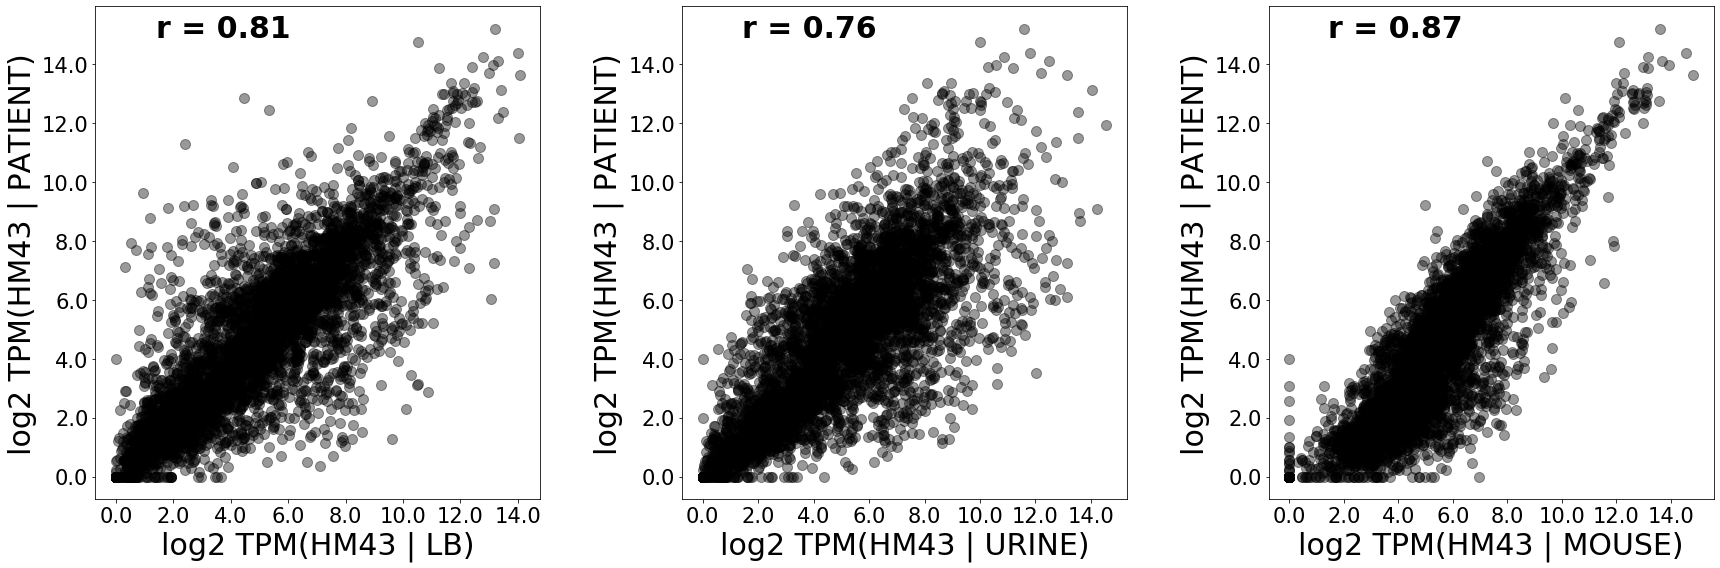

In [41]:
nc43, f = strain_analysis(orth_matrix, "HM43", hm43_counts_dir,gff_dir, results_dir)
#f.savefig(figures_dir/"Figure_3a.png", dpi=150, bbox_inches='tight')

Total Number of genes: 3821
Genes with no reference id: 333
Genes with only 1 id: 63
Genes with 5 ids: 2917
Genes in the genome: 4741
            HM56_UTI   HM56_LB   HM56_UR  HM56_mouse
HM56_UTI    1.000000  0.862459  0.732579    0.857765
HM56_LB     0.862459  1.000000  0.806200    0.836290
HM56_UR     0.732579  0.806200  1.000000    0.821368
HM56_mouse  0.857765  0.836290  0.821368    1.000000


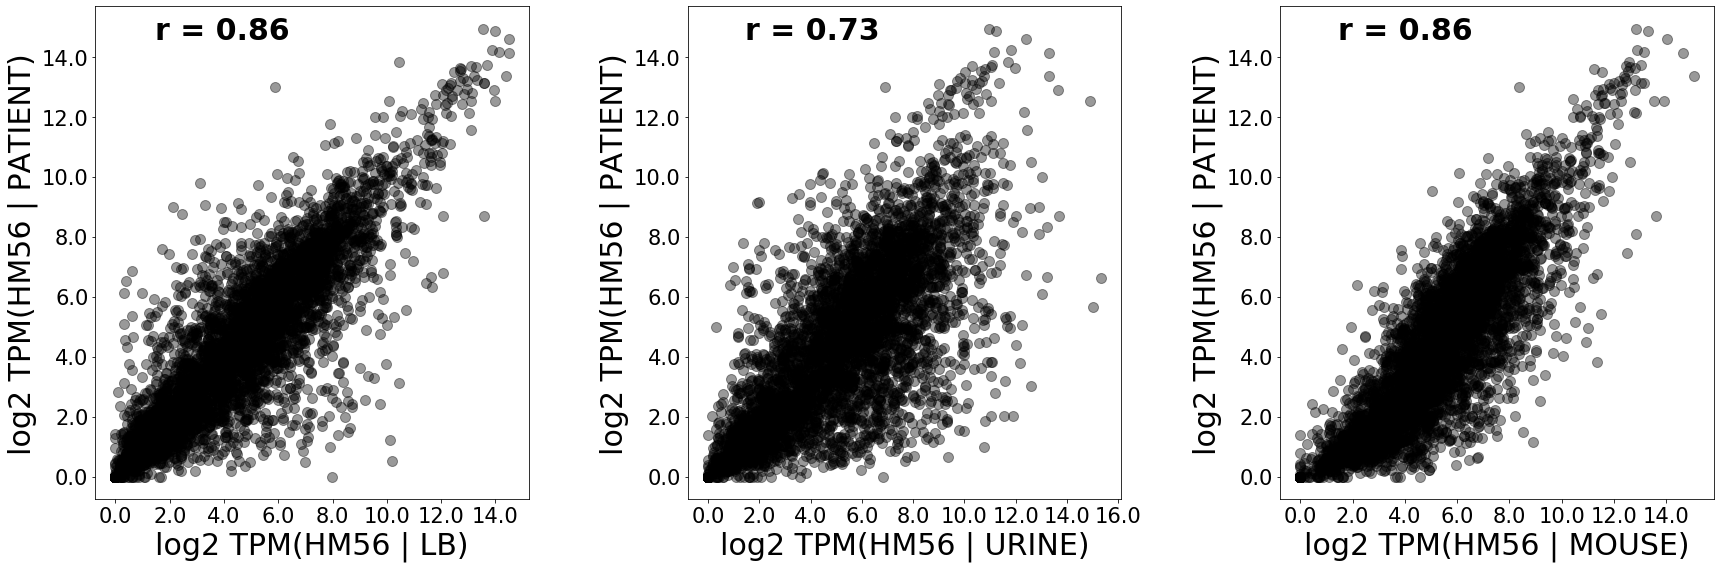

In [42]:
nc56, f = strain_analysis(orth_matrix, "HM56", hm56_counts_dir,gff_dir, results_dir)
#f.savefig(figures_dir/"Figure_3b.png", dpi=150, bbox_inches='tight')

Total Number of genes: 3963
Genes with no reference id: 394
Genes with only 1 id: 63
Genes with 5 ids: 2897
Genes in the genome: 5123
             HM86_LB   HM86_UR  HM86_UTI  HM86_mouse
HM86_LB     1.000000  0.824067  0.882717    0.862389
HM86_UR     0.824067  1.000000  0.799306    0.810125
HM86_UTI    0.882717  0.799306  1.000000    0.856091
HM86_mouse  0.862389  0.810125  0.856091    1.000000


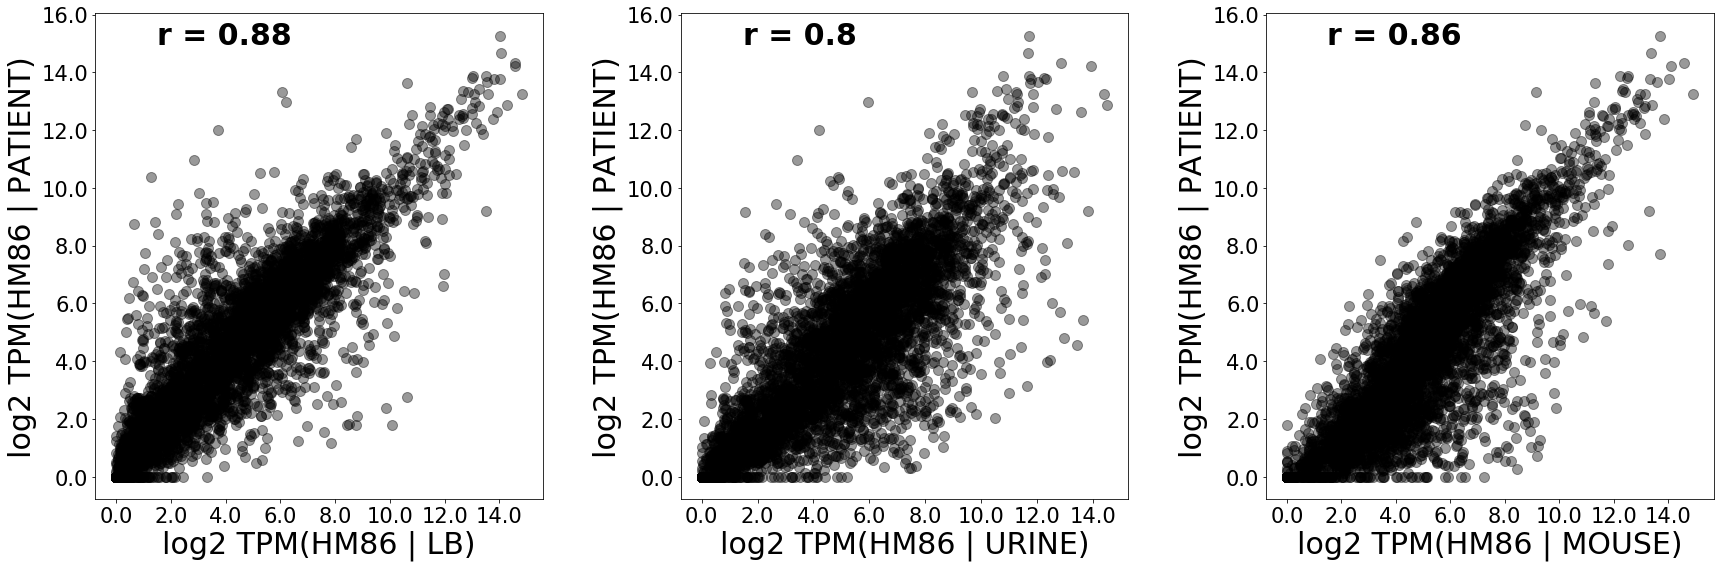

In [43]:
nc86, f = strain_analysis(orth_matrix, "HM86", hm86_counts_dir, gff_dir, results_dir)
f.savefig(figures_dir/"Figure_3c.png", dpi=150, bbox_inches='tight')

## PCA Analysis

In [10]:
norm_cnts1 = (nc43.merge(nc56, how='outer', left_index=True, right_index=True)
             .merge(nc86, how='outer', left_index=True, right_index=True))
norm_cnts = ut.get_tpms_for_prokkas(orth_matrix, norm_cnts1).dropna()

In [12]:
norm_cnts.shape

(3266, 12)

In [11]:
colData = pd.DataFrame([[c.split("_")[0] for c in norm_cnts.columns], 
                        [c.split("_")[1] for c in norm_cnts.columns],
                         [labels[c.split("_")[1]] for c in norm_cnts.columns]], columns = norm_cnts.columns,
                         index = ["strain", 'treat', 'treat_label']).T

(-75, 90)

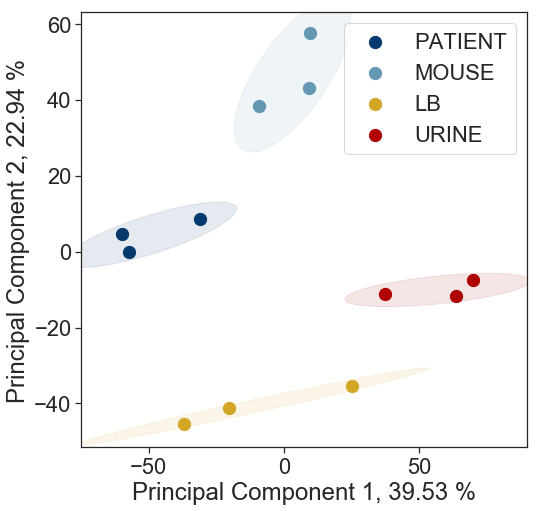

In [12]:
pDf, pc1, pc2 = ut.find_pc1_pc2(norm_cnts, colData)
f = ut.plotPCA(pDf, pc1, pc2, "treat_label", col=clrs, nameby="", el=True)
ax = f.gca()
ax.set_xlim((-75, 90))
#ax.set_ylim((-75, 75))
#f.savefig(figures_dir/"Figure_3a.png", dpi = 150, bbox_inches="tight")

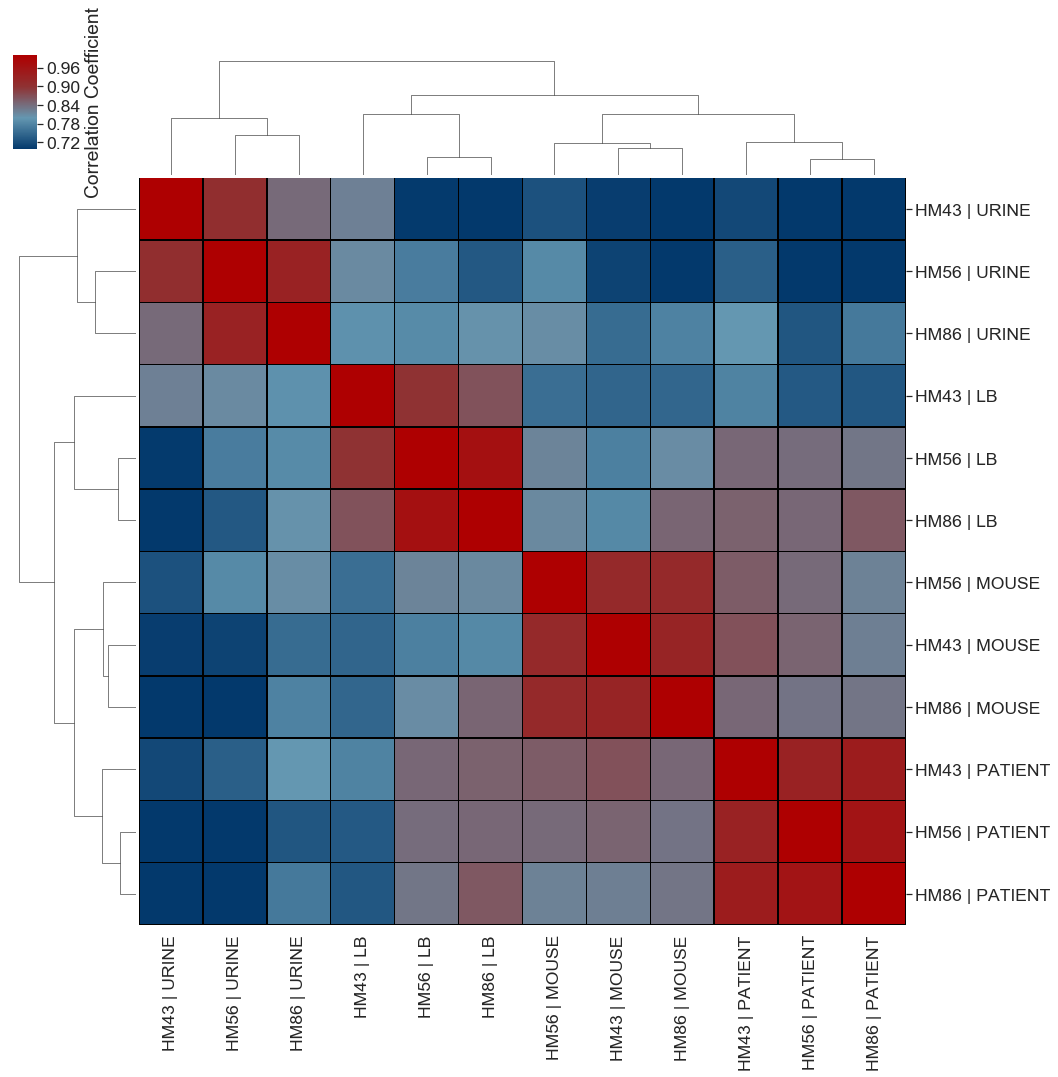

In [13]:
cmap_clrs = "#03396c #6497b1 #8f3233 #ae0001".split()
sns.set_style("white")
sns.set_context("notebook", font_scale=1.6)
my_cmap = LinearSegmentedColormap.from_list('custom blue', cmap_clrs, N=256)

correlation_df = norm_cnts.corr()
correlation_df.columns = [c.split("_")[0]+" | "+labels[c.split("_")[1]] for c in correlation_df.columns]
correlation_df.index = [c.split("_")[0]+" | "+labels[c.split("_")[1]] for c in correlation_df.index]

g = sns.clustermap(correlation_df, cmap=my_cmap,linewidths=0.5, linecolor='black',figsize=(16,16),vmin=0.7, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
#g.savefig(figures_dir/"Figure_3b_colorbar.png")

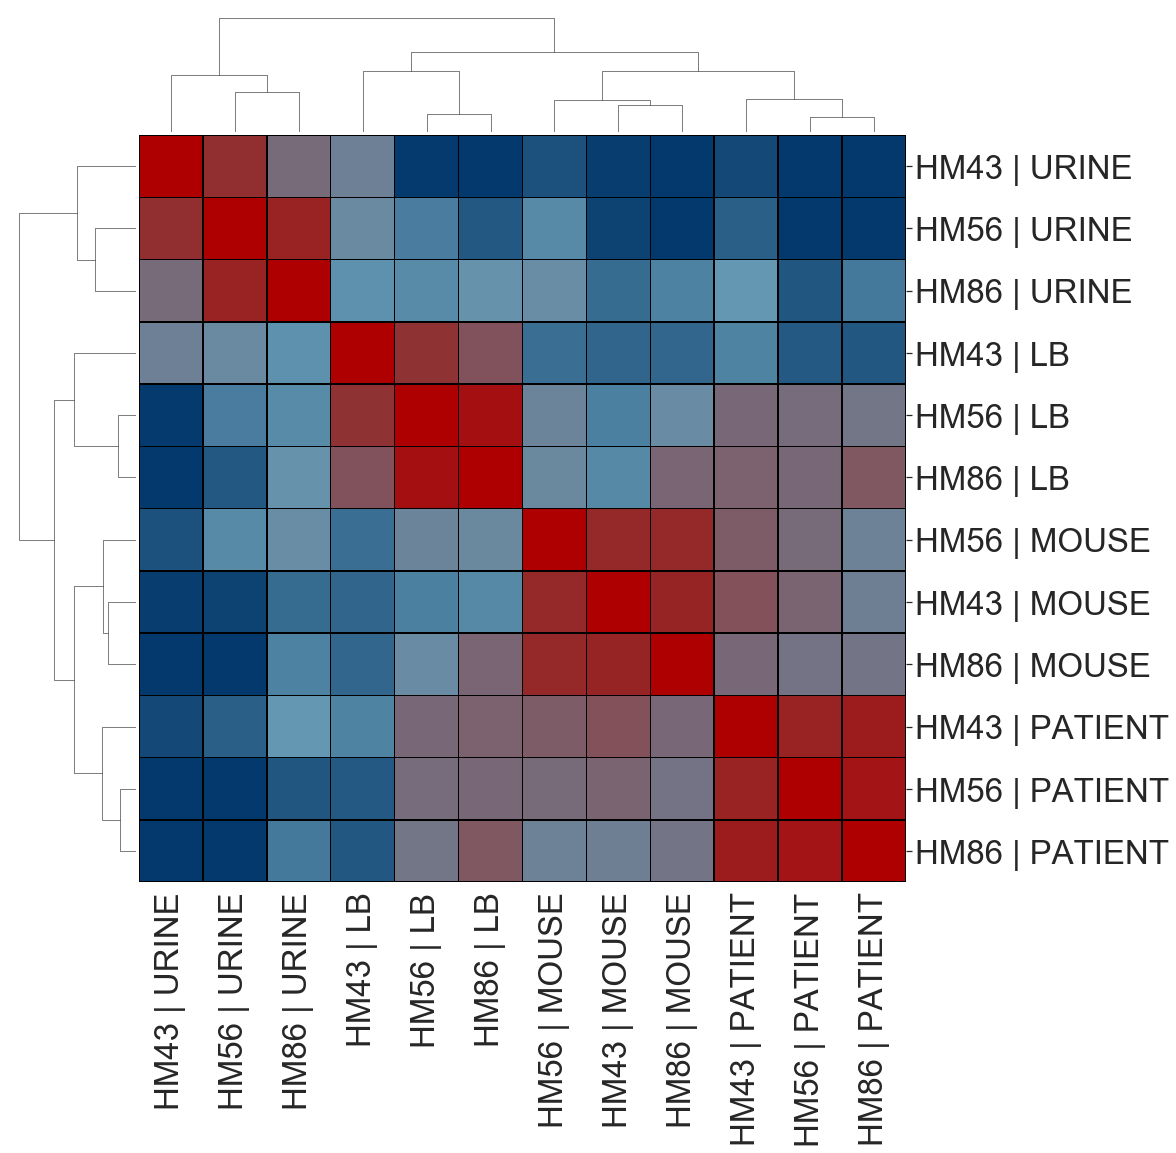

In [14]:
sns.set_context("notebook", font_scale=3)
g = sns.clustermap(correlation_df, cmap=my_cmap,linewidths=0.5, linecolor='black',figsize=(16,16),vmin=0.7, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'})
g.cax.set_visible(False)
#g.savefig(figures_dir/"Figure_3b_no_colorbar.png")

## Differential Expression Analysis

In [14]:
#...
def get_raw_counts(cnts_dir):
    pd_list = []
    for file in Path(cnts_dir).iterdir():
        if "counts.txt" in str(file):
            df = pd.read_table(file, index_col=0, names=[file.stem.split("_trimmed")[0]])
            pd_list.append(df)
    cnts = pd.concat(pd_list, axis=1)
    return cnts

dir_list = [hm43_counts_dir, hm56_counts_dir, hm86_counts_dir]

rcnts = pd.concat([get_raw_counts(d) for d in dir_list], axis=1, )
rcnts = rcnts.iloc[:-5]

to_drop = ["HM43_LB_rep2", "HM43_UR_rep2"]
rcnts = rcnts.drop(to_drop, axis=1)
rcnts.rename(columns={"HM43_UR_rep1":"HM43_UR", "HM43_LB_rep1":"HM43_LB"},  inplace=True)
frcnts = ut.get_tpms_for_prokkas(orth_matrix, rcnts).dropna()
frcnts.to_csv(results_dir/"counts_for_DE.csv")
#colData.to_csv(results_dir/"info_for_DE.csv")

# At this point running  
#python differential_analysis.py private_results/counts_for_DE.csv private_results/info_for_DE.csv treat_label results/de_analysis/


In [15]:
de_analysis_dir = Path("results/de_analysis/edited")
uti_mouse = pd.read_csv(de_analysis_dir/"PATIENT_vs_MOUSE_all_genes_edited.csv", index_col=0)
uti_lb = pd.read_csv(de_analysis_dir/"PATIENT_vs_LB_all_genes_edited.csv", index_col=0)
uti_ur = pd.read_csv(de_analysis_dir/'PATIENT_vs_URINE_all_genes_edited.csv', index_col=0)
mouse_lb = pd.read_csv(de_analysis_dir/'MOUSE_vs_LB_all_genes_edited.csv', index_col=0)
mouse_ur = pd.read_csv(de_analysis_dir/'MOUSE_vs_URINE_all_genes_edited.csv', index_col=0)
uti_mouse.head()

baseMean  log2FoldChange     lfcSE     stat    pvalue  padj  \
77094_rsxE   2313.192929        1.446403  0.635486  0.70246  0.482392   1.0   
78577_ispB   3214.863421        0.575223  0.238292  0.00000  1.000000   1.0   
77329_yebC  14889.531974        0.654174  0.390623  0.00000  1.000000   1.0   
76065_fepD    357.185607        0.674847  0.415054  0.00000  1.000000   1.0   
77731_alaA   5933.112898        0.771903  0.425008  0.00000  1.000000   1.0   

           Genome Gene_ID  Name  \
77094_rsxE   K-12   b1632  rsxE   
78577_ispB   K-12   b3187  ispB   
77329_yebC   K-12   b1864  yebC   
76065_fepD   K-12   b0590  fepD   
77731_alaA   K-12   b2290  alaA   

                                                  Description  
77094_rsxE         SoxR [2Fe-2S] reducing system protein RsxE  
78577_ispB          all-trans-octaprenyl-diphosphate synthase  
77329_yebC            putative transcriptional regulator YebC  
76065_fepD  ferric enterobactin ABC transporter membrane s...  
77731_alaA          glutamate--pyruvate aminotransferase AlaA

In [16]:
de_results = uti_mouse
de_up = de_results[(de_results.log2FoldChange >= 1)& (de_results.padj < 0.05)]
de_down = de_results[(de_results.log2FoldChange <= -1)& (de_results.padj < 0.05)]
print("Down: ", de_down.shape[0]) # 146
print("Up: ", de_up.shape[0]) # 33

Down:  146
Up:  33


In [17]:
go_results = (pd.read_csv("results/de_analysis/PATIENT_MOUSE_pathway_analysis_BP.csv", index_col=0)
             .sort_values(by=["Annotated"], ascending=False))
go_results

GO.ID  Annotated  Significant  Expected  elimFisher  \
28  GO:0015711         96           13      5.45     0.02985   
21  GO:0015849         74           12      4.20     0.01455   
34  GO:0046942         73           11      4.15     0.03659   
43  GO:1903825         51            9      2.90     0.04620   
32  GO:0006928         43            6      2.44     0.03201   
7   GO:0072329         42            8      2.39     0.00197   
31  GO:0071973         32            5      1.82     0.03182   
30  GO:0097588         32            5      1.82     0.03182   
29  GO:0001539         32            5      1.82     0.03182   
45  GO:0044242         15            3      0.85     0.04924   
44  GO:0016042         15            3      0.85     0.04924   
35  GO:1901616         14            3      0.80     0.04105   
33  GO:0009062         13            3      0.74     0.03361   
26  GO:0034440         12            3      0.68     0.02695   
24  GO:0046164         12            3      0.68     0.02695   
25  GO:0019395         12            3      0.68     0.02695   
5   GO:0006113         11            5      0.62     0.00019   
22  GO:0006635         10            3      0.57     0.01597   
18  GO:0044780          7            3      0.40     0.00528   
36  GO:0019586          6            2      0.34     0.04128   
38  GO:0046397          6            2      0.34     0.04128   
10  GO:0009437          6            3      0.34     0.00315   
37  GO:0046396          6            2      0.34     0.04128   
42  GO:0055088          6            2      0.34     0.04128   
41  GO:0033539          6            2      0.34     0.04128   
40  GO:0009071          6            2      0.34     0.04128   
39  GO:0019698          6            2      0.34     0.04128   
27  GO:0015740          5            2      0.28     0.02857   
9   GO:0015751          4            4      0.23     0.00309   
8   GO:0019852          4            4      0.23     0.00309   
6   GO:0046168          4            3      0.23     0.00069   
23  GO:0032329          4            2      0.23     0.01780   
20  GO:0042906          3            2      0.17     0.00924   
4   GO:0015882          3            3      0.17     0.00018   
19  GO:0019569          3            2      0.17     0.00924   
12  GO:0019546          2            2      0.11     0.00320   
13  GO:0042882          2            2      0.11     0.00320   
14  GO:0032263          2            2      0.11     0.00320   
15  GO:0032264          2            2      0.11     0.00320   
16  GO:0019854          2            2      0.11     0.00320   
17  GO:0006325          2            2      0.11     0.00320   
11  GO:0009115          2            2      0.11     0.00320   

                                                 Term  \
28                            organic anion transport   
21                             organic acid transport   
34                          carboxylic acid transport   
43               organic acid transmembrane transport   
32          movement of cell or subcellular component   
7               monocarboxylic acid catabolic process   
31   bacterial-type flagellum-dependent cell motility   
30  archaeal or bacterial-type flagellum-dependent...   
29        cilium or flagellum-dependent cell motility   
45                   cellular lipid catabolic process   
44                            lipid catabolic process   
35         organic hydroxy compound catabolic process   
33                       fatty acid catabolic process   
26                                    lipid oxidation   
24                          alcohol catabolic process   
25                               fatty acid oxidation   
5                                        fermentation   
22                          fatty acid beta-oxidation   
18                  bacterial-type flagellum assembly   
36                    galacturonate metabolic process   
38                    galacturonate catabolic process   
10

In [18]:
all_transport_genes = go_results[go_results.Term.str.contains('transport')].DEGenesInTerm.values
inter = [f.split(',') for f in all_transport_genes ]
final = set([x for f in inter for x in f])
de_transport = de_results[de_results.Name.isin(final)]

In [19]:
all_transport_genes = go_results[go_results.Term.str.contains('catabolic')].DEGenesInTerm.values
inter = [f.split(',') for f in all_transport_genes ]
final = set([x for f in inter for x in f])
de_catabolic = de_results[de_results.Name.isin(final)]

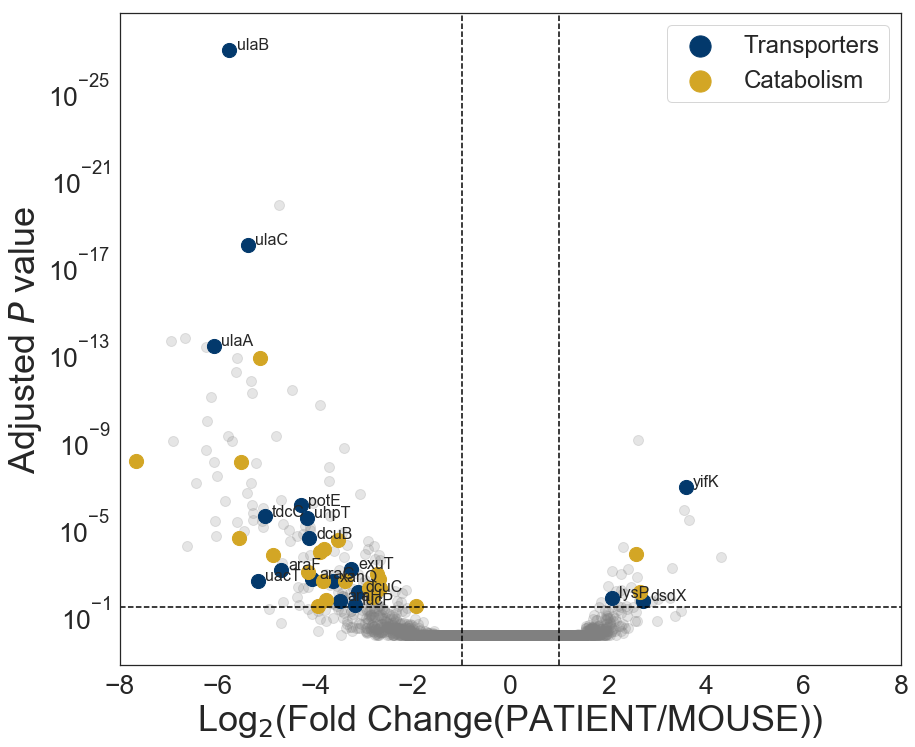

In [22]:
# Drawing the volcano plot


sns.set_context("notebook", font_scale=2.4)
fig = plt.figure(figsize=(14,12))
plt.yscale('log')
plt.xlim(-8, 8)
plt.rcParams["lines.markersize"] = 10.0
plt.scatter(de_results.log2FoldChange, de_results.padj, color='grey', s=100,alpha=0.2, label=None)
plt.scatter(de_transport.log2FoldChange, de_transport.padj, color=clrs[0], s=200,label="Transporters")
plt.scatter(de_catabolic.log2FoldChange, de_catabolic.padj, color=clrs[2], s=200, label='Catabolism')
for i, txt in enumerate(de_transport.Name):
    x = de_transport.log2FoldChange
    y = de_transport.padj
    plt.gca().annotate(txt, (x[i], y[i]), xytext=(x[i]+0.15, y[i]), fontsize=16)

#plt.scatter(de_catabolic.log2FoldChange, de_catabolic.padj, color="#74d600", s=200,  label="Catabolic Process")
# plt.scatter(sugar_aa_met_df.log2FoldChange, sugar_aa_met_df.padj, color=col5, 
#             label="Sugar Catabolism/Amino Acid Biosynthesis")
# plt.scatter(sugar_tt_df.log2FoldChange, sugar_tt_df.padj, color="#00ced1",  label="Sugar Transporters")



plt.axvline(-1, color='k', linestyle="--",)
plt.axvline(1, color='k', linestyle="--")
plt.axhline(0.05, color='k', linestyle="--")
plt.xlabel("Log$_2$(Fold Change(PATIENT/MOUSE))", fontsize=36)
plt.ylabel("Adjusted $\itP$ value", fontsize=36)
plt.gca().invert_yaxis()

plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.8, fontsize=24)

fig.savefig(figures_dir/"Figure_4a.png", dpi=150, bbox_inches="tight")
#plt.legend(markerscale=1.5, frameon=True, facecolor="white", framealpha=0.5)
fig.savefig(figures_dir/"Figure_3a.png", dpi=150, bbox_inches="tight")

In [23]:
mouse_lb_short = (mouse_lb[["log2FoldChange", "Gene_ID", "Name", "padj"]]
                  .rename({"log2FoldChange": "log2FC_mouse", "padj":"padj_mouse"}, axis=1))
uti_lb_short = (uti_lb[["log2FoldChange", "padj"]].
               rename({"log2FoldChange": "log2FC_uti", "padj":"padj_uti"}, axis=1))
mouse_uti_lb = uti_lb_short.merge(mouse_lb_short, right_index=True, left_index=True)
mouse_uti_lb= mouse_uti_lb[(mouse_uti_lb.padj_mouse < 0.05) & (mouse_uti_lb.padj_uti < 0.05)]
mouse_uti_lb_up = mouse_uti_lb[(mouse_uti_lb.log2FC_uti > 1) & (mouse_uti_lb.log2FC_mouse > 1)]
mouse_uti_lb_down = mouse_uti_lb[(mouse_uti_lb.log2FC_uti < -1) & (mouse_uti_lb.log2FC_mouse < -1)]

In [24]:
mouse_uti_lb_down.to_excel(results_dir/"HOST_DOWN_VS_LB.xlsx")
mouse_uti_lb_up.to_excel(results_dir/"HOST_UP_VS_LB.xlsx")

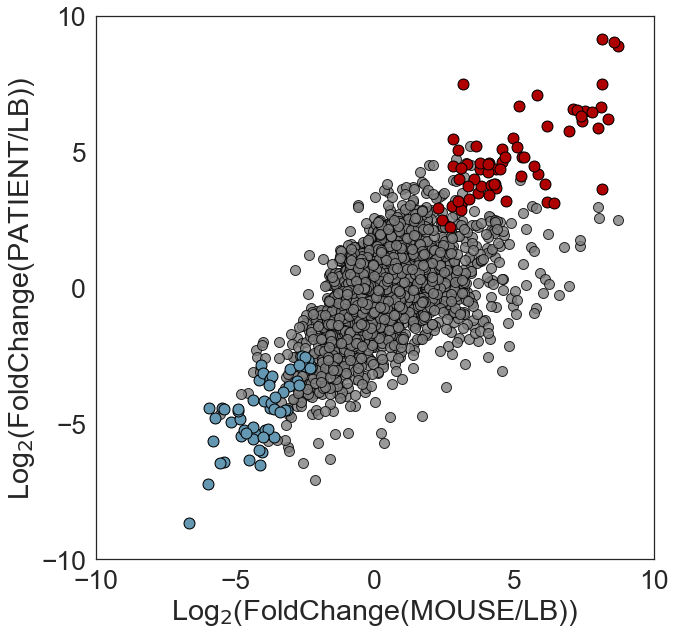

In [25]:
sns.set_context("notebook", font_scale=2.4)
sns.set_style('white')
f = plt.figure(figsize=(10,10))
plt.scatter(mouse_lb.log2FoldChange, uti_lb.log2FoldChange, color='grey', s=100, edgecolors='black',alpha=0.8 )
plt.scatter(mouse_uti_lb_up.log2FC_mouse, mouse_uti_lb_up.log2FC_uti, color=clrs[3], 
            edgecolors='black',s=120)
plt.scatter(mouse_uti_lb_down.log2FC_mouse, mouse_uti_lb_down.log2FC_uti, color=clrs[1], 
            edgecolors='black',s=120)
plt.xlabel("Log$_2$(FoldChange(MOUSE/LB))")
plt.ylabel("Log$_2$(FoldChange(PATIENT/LB))")

plt.locator_params(nbins=5)
plt.ylim(-10,10)
plt.xlim(-10,10)
f.savefig(figures_dir/"Figure_4b.png", dpi=150, bbox_inches="tight")

In [26]:
mouse_ur_short = (mouse_ur[["log2FoldChange", "Gene_ID", "Name", "padj"]]
                  .rename({"log2FoldChange": "log2FC_mouse", "padj":"padj_mouse"}, axis=1))
uti_ur_short = (uti_ur[["log2FoldChange", "padj"]].
               rename({"log2FoldChange": "log2FC_uti", "padj":"padj_uti"}, axis=1))
mouse_uti_ur = uti_ur_short.merge(mouse_ur_short, right_index=True, left_index=True)
mouse_uti_ur= mouse_uti_ur[(mouse_uti_ur.padj_mouse < 0.05) & (mouse_uti_ur.padj_uti < 0.05)]
mouse_uti_ur_up = mouse_uti_ur[(mouse_uti_ur.log2FC_uti > 1) & (mouse_uti_ur.log2FC_mouse > 1)]
mouse_uti_ur_down = mouse_uti_ur[(mouse_uti_ur.log2FC_uti < -1) & (mouse_uti_ur.log2FC_mouse < -1)]

In [27]:
mouse_uti_ur_down.to_excel(results_dir/"HOST_DOWN_VS_URINE.xlsx")
mouse_uti_ur_up.to_excel(results_dir/"HOST_UP_VS_URINE.xlsx")

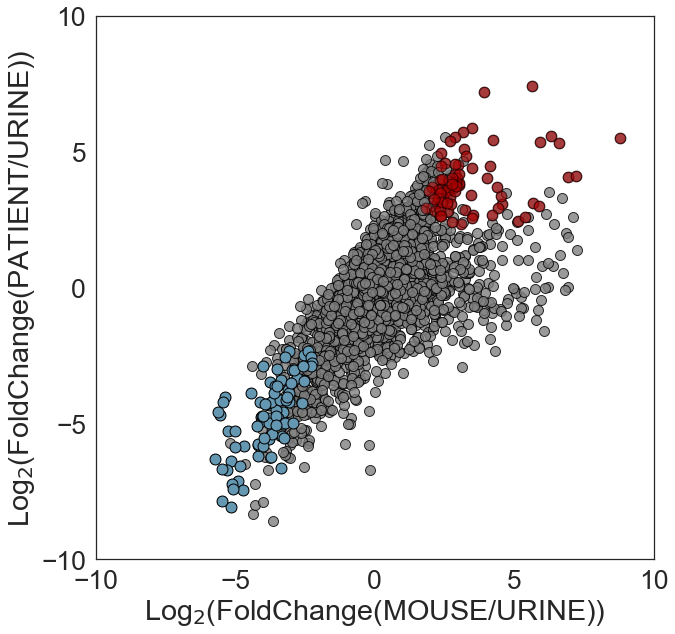

In [28]:
sns.set_context("notebook", font_scale=2.4)
sns.set_style('white')
f = plt.figure(figsize=(10,10))
plt.scatter(mouse_ur.log2FoldChange, uti_ur.log2FoldChange, color='grey', s=100, edgecolors='black',alpha=0.8 )
plt.scatter(mouse_uti_ur_up.log2FC_mouse, mouse_uti_ur_up.log2FC_uti, color=clrs[3], 
            edgecolors='black',s=120, alpha=0.6)
plt.scatter(mouse_uti_ur_down.log2FC_mouse, mouse_uti_ur_down.log2FC_uti, color=clrs[1], 
            edgecolors='black',s=120)
plt.xlabel("Log$_2$(FoldChange(MOUSE/URINE))")
plt.ylabel("Log$_2$(FoldChange(PATIENT/URINE))")
plt.locator_params(nbins=5)
plt.ylim(-10,10)
plt.xlim(-10,10)
f.savefig(figures_dir/"Figure_4c.png", dpi=150, bbox_inches="tight")

[('PATIENT', 'MOUSE'),
 ('PATIENT', 'LB'),
 ('PATIENT', 'URINE'),
 ('MOUSE', 'LB'),
 ('MOUSE', 'URINE'),
 ('LB', 'URINE')]

## Functional groups

In [124]:
from Bio.KEGG import REST

paths = ["path:eco00561 ", "path:eco00564"]

def get_genes_for_pathway(pathway):
    genes = []
    pathway_file = REST.kegg_get(pathway).read()
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            gene_identifiers = line[12:].split("; ")[0]
            gene_id, gene_symbol = gene_identifiers.split()
            if not gene_symbol in genes:
                genes.append(gene_id)
    return genes
lipid_genes = get_genes_for_pathway("path:eco00561")
# Lipid Metabolism

lipid_pathways = ["path:ecc00561", "path:ecc00564", "path:ecc00565", "path:ecc00600"]

#lipid_genes = [get_genes_for_pathway(pathway) for pathway in lipid_pathways]
lipid_genes = []
for pathway in lipid_pathways:
    print(pathway)
    get_genes_for_pathway("path:eco00561")
lipid_genes
    

# Most Variable Genes

In [ ]:
x = pd.DataFrame([residuals.mean(axis=1), residuals.notnull().sum(axis=1)]).T
f = plt.figure(figsize=(8,8))
plt.scatter(x[1], x[0], marker='.',s=8)

sorted(x[1].unique())

In [ ]:
fres = abs(residuals)

In [ ]:
fres.mean(axis=1).std()

In [ ]:
fres.head()

In [ ]:
th = 2* fres.mean(axis=1).std()
th

In [ ]:
residuals.mean(axis=1).min()

In [ ]:
fres.mean(axis=1).hist()

In [ ]:
conserved = fres.mean(axis=1).nsmallest(100)
conserved = orth_matrix.loc[conserved.index].merge(pd.DataFrame(conserved), left_index=True, right_index=True)
conserved
conserved.sort_values(['K-12', 'CFT073', '536', 'F11'])[ref_genomes+[0]].to_csv(results_dir/Path("human_conserved.csv"))

In [ ]:
var = fres[fres.mean(axis=1) > 0.8]
var.shape

In [ ]:
var.mean(axis=1).sort_values(ascending=False).to_csv(results_dir/Path("human_variable.csv"))

In [ ]:
var_genes = var.index

In [ ]:
human_variable = orth_matrix.loc[var_genes].merge(pd.DataFrame(var.mean(axis=1)), left_index=True, right_index=True)

In [ ]:
human_variable.to_csv(results_dir/Path("human_variable.csv"))


In [ ]:
human_variable.sort_values(['K-12', 'CFT073', '536', 'F11'])[ref_genomes].to_csv(results_dir/Path("human_variable.csv"))

In [ ]:
residuals.mean(axis=1).max()

In [ ]:
t2 = pd.DataFrame([residuals, residuals2]).T
t2

In [ ]:
test.corr()

In [ ]:
test = orth_matrix.merge(norm_counts[['HM56_UTI']], how='outer',left_on="HM56", right_index=True)
test[['HM56', 'HM56_UTI']].tail()

# Functional Groups

In [45]:
fgroups = pd.read_csv(functional_groups_file, index_col=0) 
to_keep = ['Functional Group', "Description", "Gene_ID"]
fgroups = fgroups[to_keep]


In [30]:
fun_orth = pd.read_csv("private_data/2019-06-09_virulence_orthologs.csv", index_col=0).dropna(how='all')
fun_orth.index = [i.split("|")[0] for i in fun_orth.index]
fun_orth = fun_orth[["HM43", "HM56", "HM86"]]
fun_cnts = ut.get_tpms_for_prokkas(fun_orth, norm_cnts1)
fun_cnts = fun_cnts.merge(fgroups, left_index=True, right_on="Gene_ID")
fun_cnts.shape

(250, 15)

In [115]:
 

def plot_functional_group(df, group_alias, groupby="Description",
                          conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), 
                                        ("HM43_mouse", "HM43_UTI")]):
   
    m_list = ['o', 'v', 's','*', 'p', 'h', '+', 8, '>', 'x']
    c_list = ["#44bec7", "#ffc300",  "#234d20","#d696bb", "#fa3c4c", "#0084ff",
             "#36802d", "#c9df8a", "#673888", "orange"]
   
    for t in conditions:
        k=0
        fig = plt.figure(figsize=(8,8))
        
        for i, g in df.groupby(groupby):
           
            plt.scatter(x=t[0], y=t[1], data=g, marker=m_list[k], color= c_list[k],
                        s=200,label=i)
            k+=1
            plt.legend(fontsize=24, bbox_to_anchor=(1.2, 1))

            #plt.scatter( x = t[0], y =t[1], data=iron_df, color = 'black');
        x_lab = t[0].split("_")
        y_lab = t[1].split("_")
        plt.xlabel("log$_2$TPM({}|{})".format(x_lab[0], labels[x_lab[1]]), fontsize=24)
        plt.ylabel("log$_2$TPM({}|{})".format(y_lab[0], labels[y_lab[1]]),fontsize=24)
        plt.plot([-1, 14], [-1, 14], 'k-')
        plt.locator_params(nbins=8)
        plt.xlim(-1, 14)
        plt.ylim(-1, 14)
        fig.savefig(figures_dir/"Figure_5_{}_{}.png".format(group_alias, t[0]),
                    dpi=150, bbox_inches='tight')

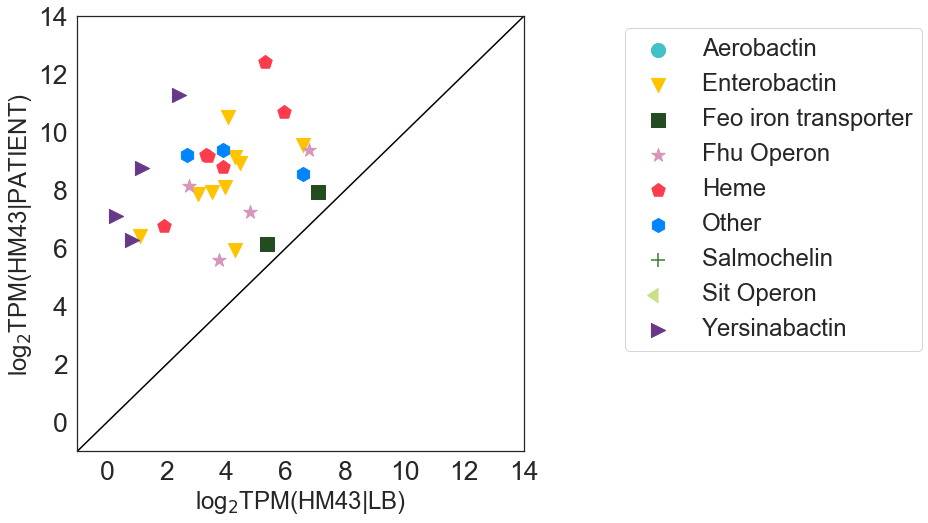

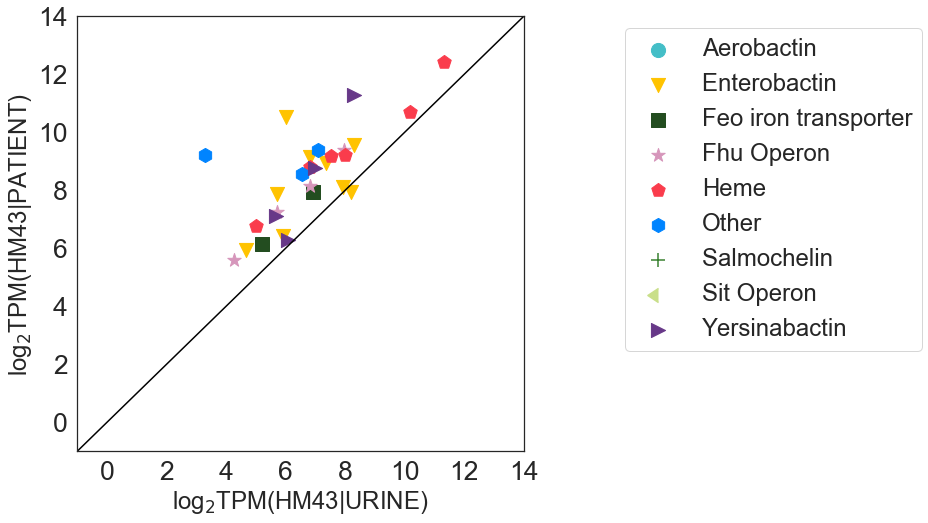

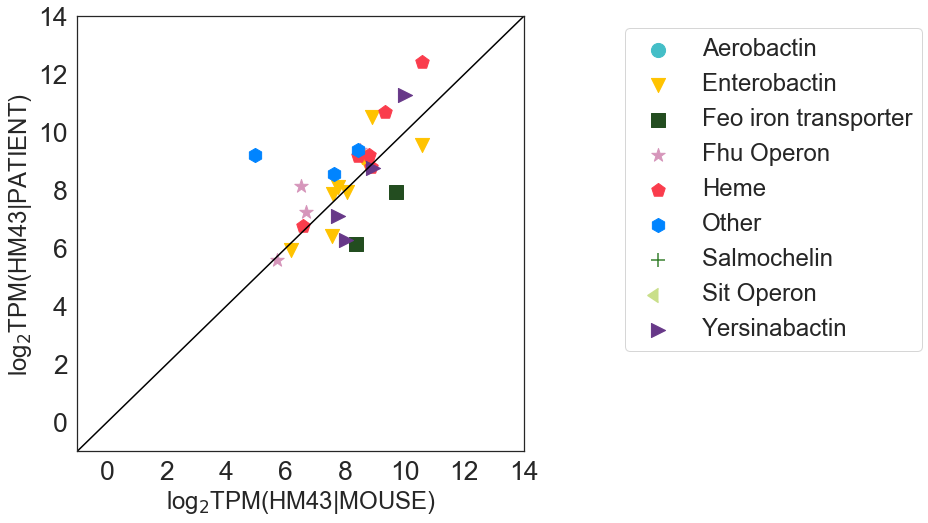

In [116]:
df = fun_cnts[fun_cnts["Functional Group"] == "Iron Acquisition"]
plot_functional_group(df,  'iron')

In [109]:
cond2 = [("HM56_LB", "HM56_UTI"), ("HM56_UR", "HM56_UTI"), ("HM56_mouse", "HM56_UTI")]
cond3 = [("HM86_LB", "HM86_UTI"), ("HM86_UR", "HM86_UTI"), ("HM86_mouse", "HM86_UTI")]

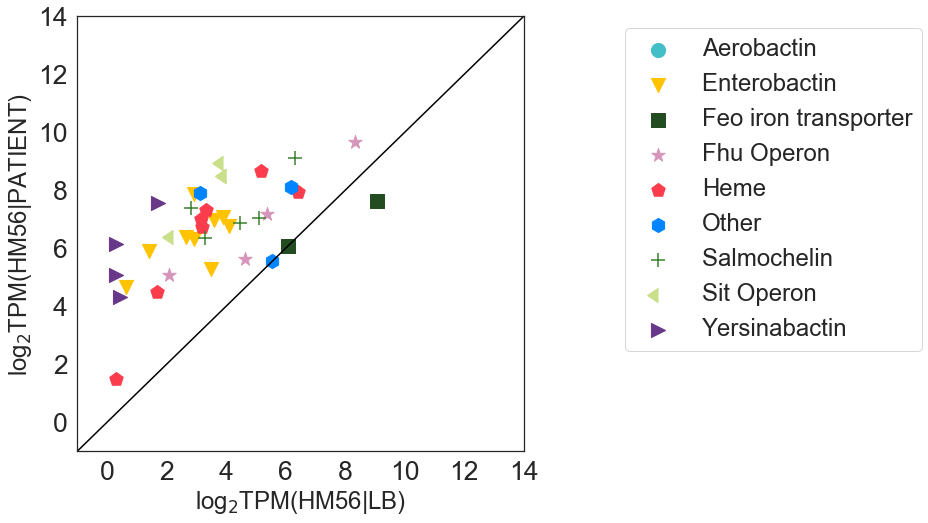

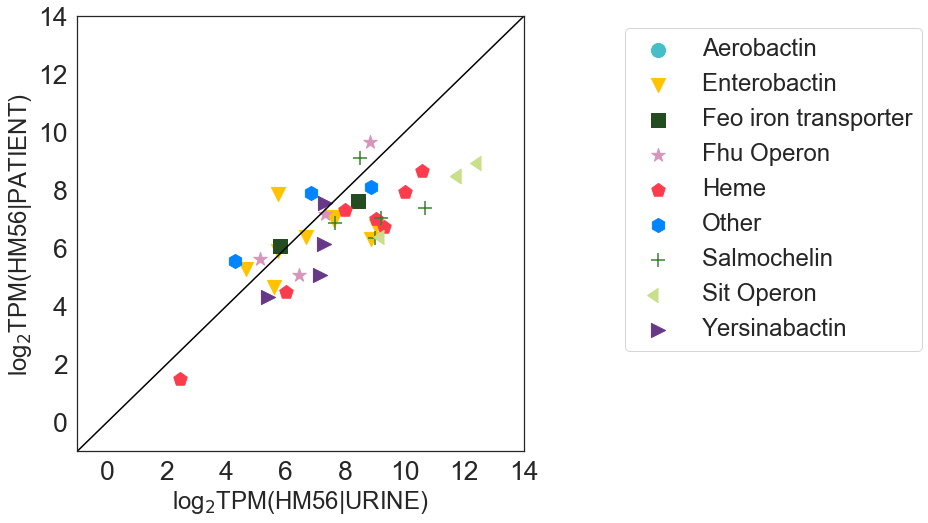

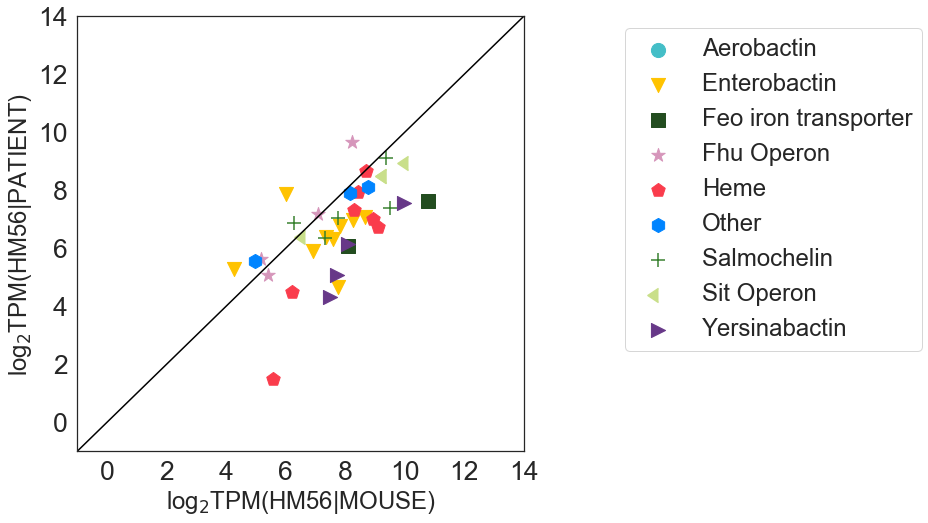

In [117]:
plot_functional_group(df,  group_alias='iron', conditions=cond2)

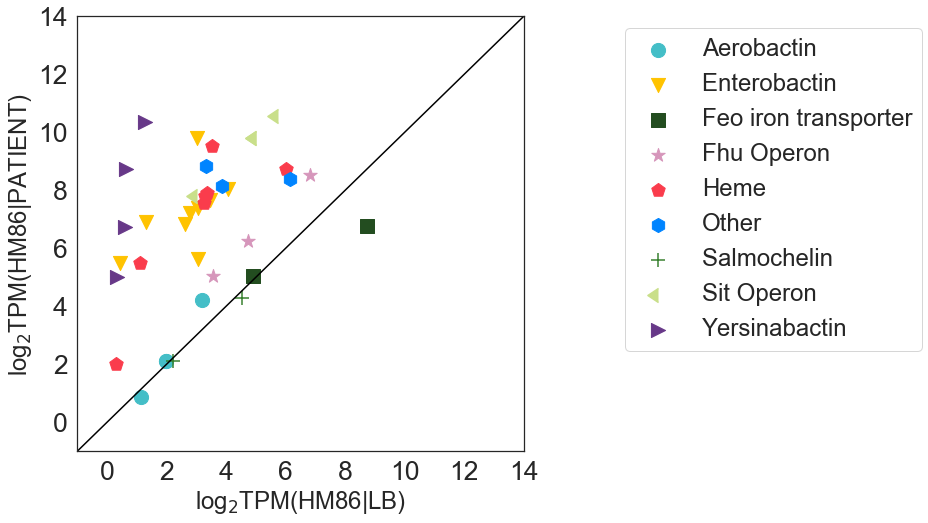

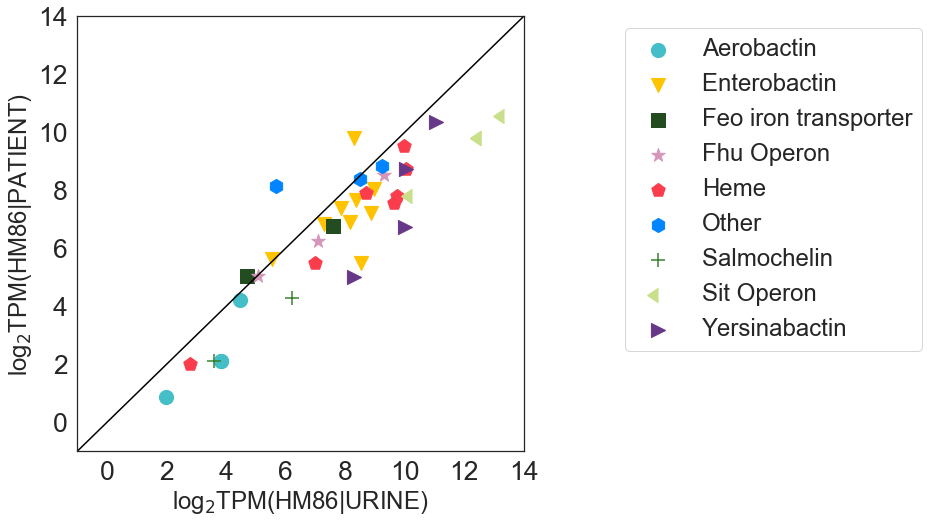

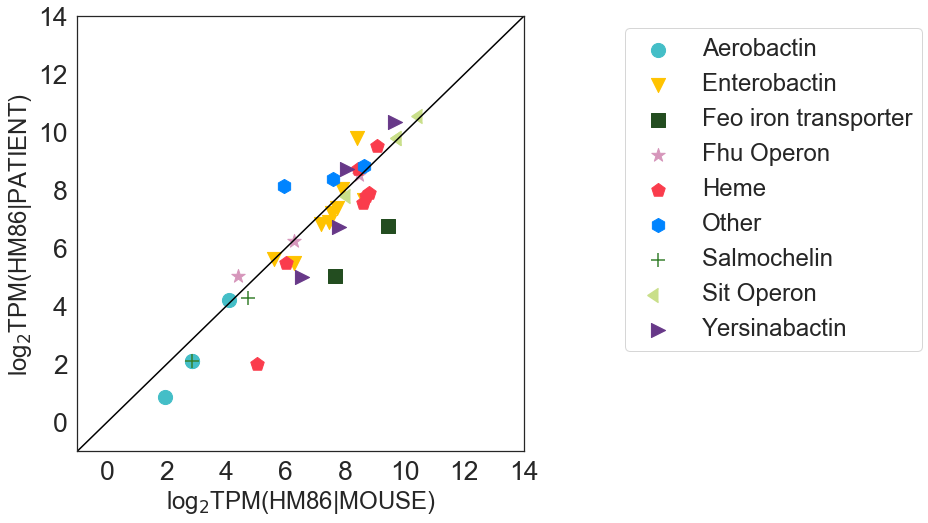

In [118]:
plot_functional_group(df,  'iron', conditions=cond3)

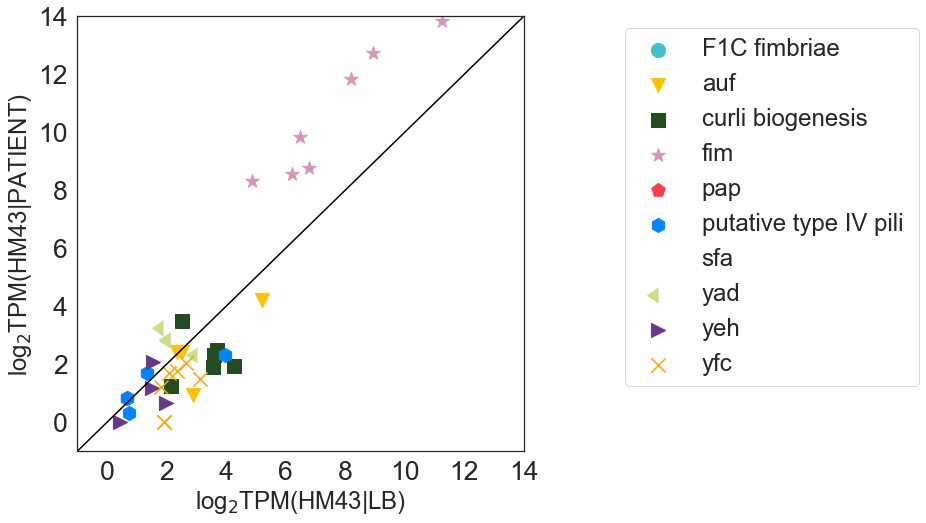

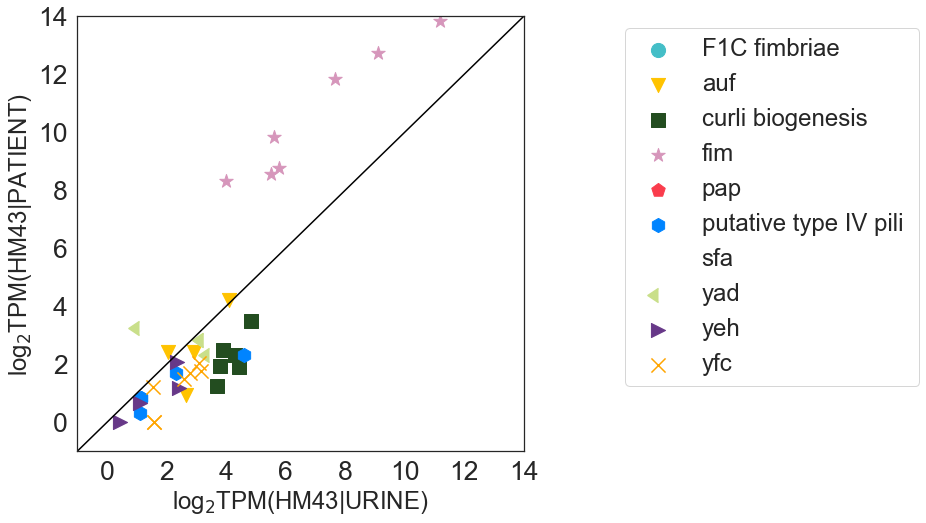

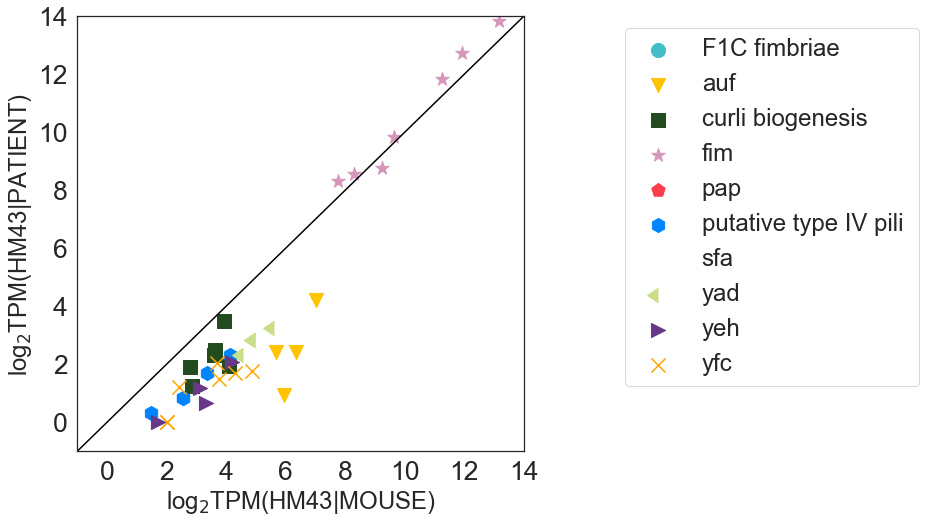

In [119]:
df = fun_cnts[fun_cnts["Functional Group"] == "adherence"]
plot_functional_group(df, 'adhesins')

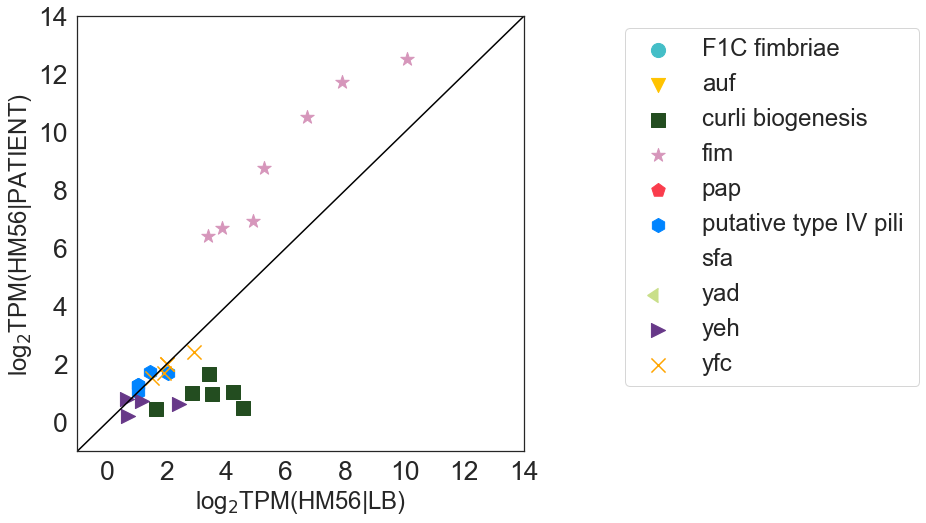

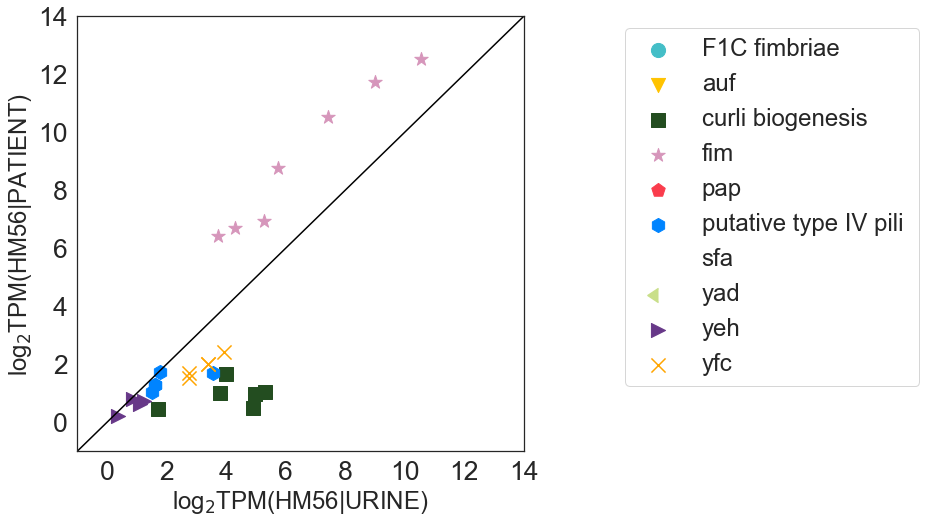

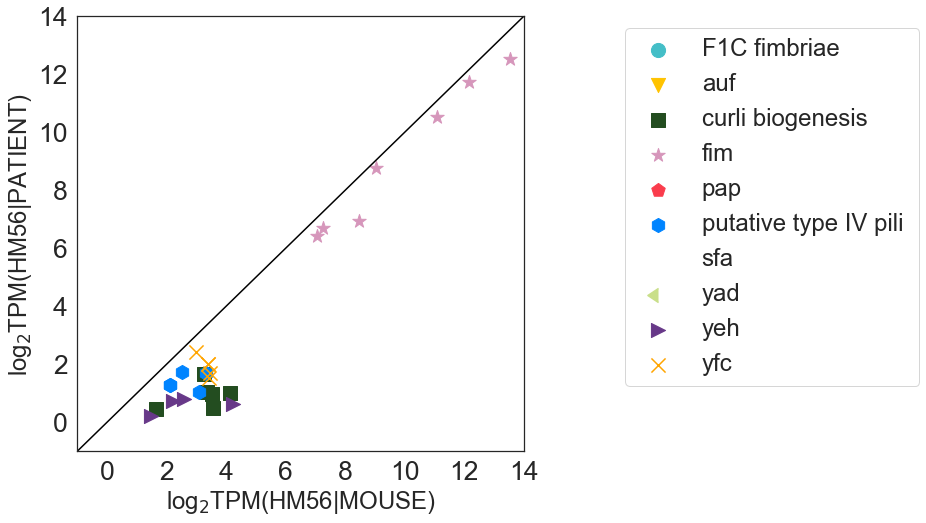

In [120]:
plot_functional_group(df,  group_alias='adherence', conditions=cond2)

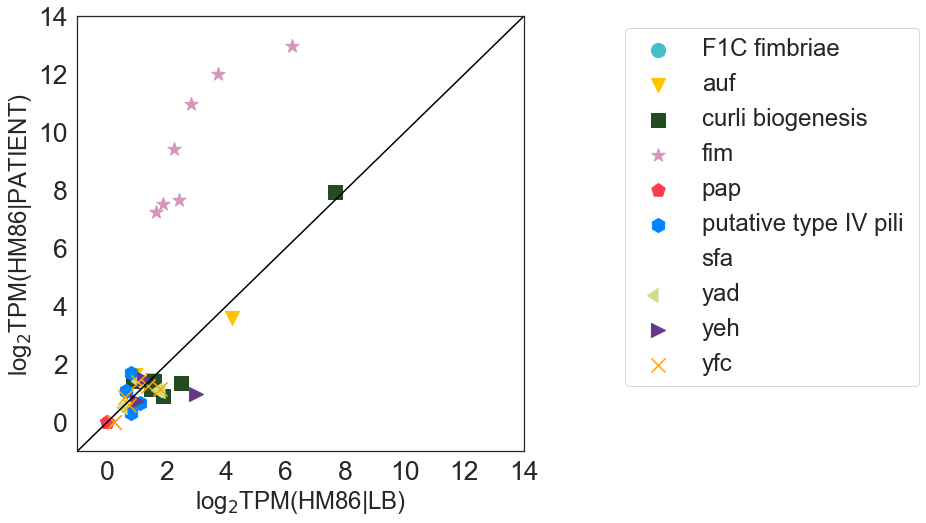

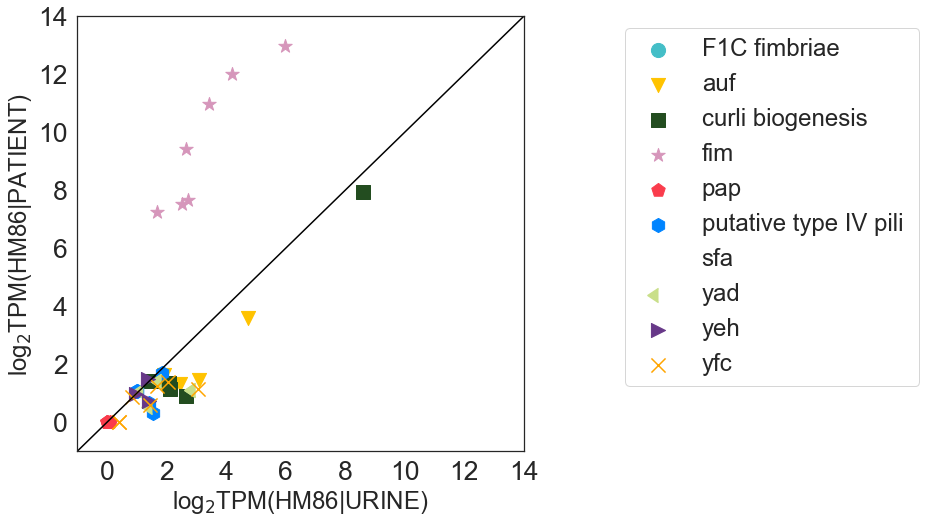

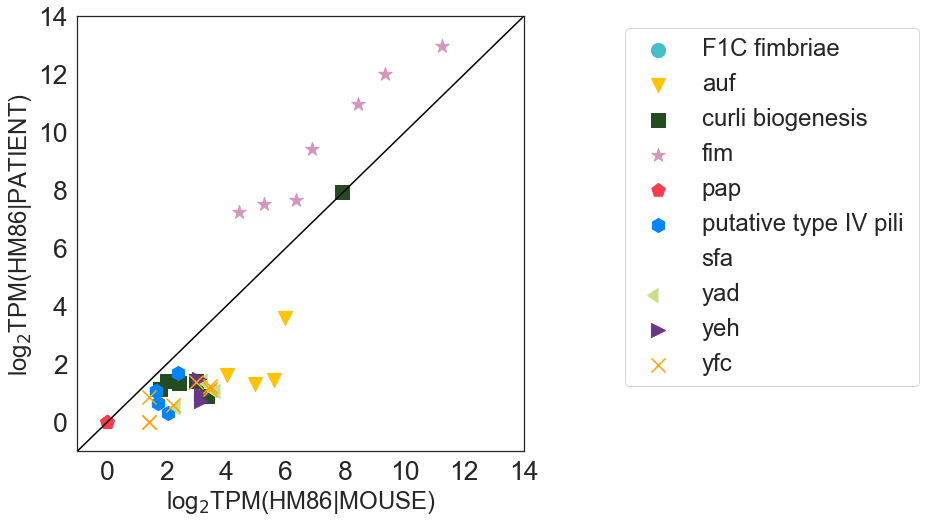

In [121]:
plot_functional_group(df,  group_alias='adherence', conditions=cond3)

In [84]:
mgroups = pd.read_csv("private_data/metabolism_gene_info.csv", index_col=1) 
met_orth = pd.read_csv("private_data/metabolism_ortho/2019-06-10_virulence_orthologs.csv", index_col=0).dropna(how='all')
met_orth.index = [i.split("|")[0] for i in met_orth.index]
met_orth = met_orth[["HM43", "HM56", "HM86"]]
met_cnts = ut.get_tpms_for_prokkas(met_orth, norm_cnts1)
met_cnts = met_cnts.merge(mgroups, left_index=True, right_index=True)
met_cnts.head()



HM43_UTI  HM43_mouse    HM43_LB   HM43_UR  HM56_UTI    HM56_LB  \
b2280  7.634215    8.958626  10.232103  9.618962  7.209909   8.991244   
b2288  9.270698    9.968266  10.365832  9.561303  9.104816  10.151435   
b1224  4.521132    8.514720   2.098922  3.237265  4.899009   3.434675   
b0721  4.982291    5.882744  10.248703  8.545015  2.416368   8.729104   
b2283  6.773434    7.930697   8.877717  7.509770  6.236533   7.889173   

         HM56_UR  HM56_mouse   HM86_LB   HM86_UR  HM86_UTI  HM86_mouse Genome  \
b2280   8.981168    8.938481  8.930425  8.479743  7.128449    8.868462    eco   
b2288  10.037124    9.485513  9.997590  9.745297  9.705852    9.627848    eco   
b1224   2.991230    6.914377  2.223253  2.909277  5.142524    6.001879    eco   
b0721   6.860606    5.382074  8.406720  7.079402  4.103650    5.013563    eco   
b2283   7.514709    7.273491  7.501694  7.698727  6.451512    7.510985    eco   

                    Function Name  
b2280    Aerobic Respiration  Sdh  
b2288    Aerobic Respiration  Sdh  
b1224  Anaerobic Respiration  Nar  
b0721    Aerobic Respiration  Sdh  
b2283    Aerobic Respiration  Sdh

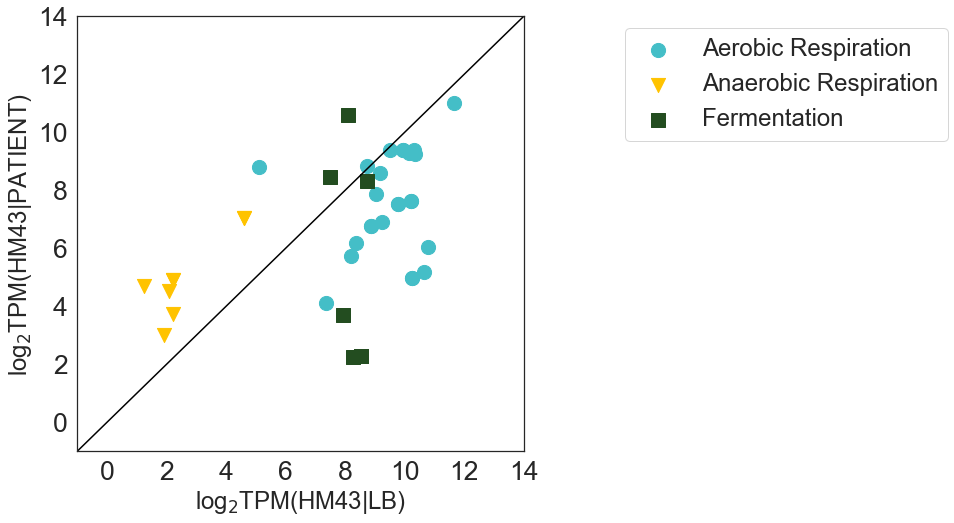

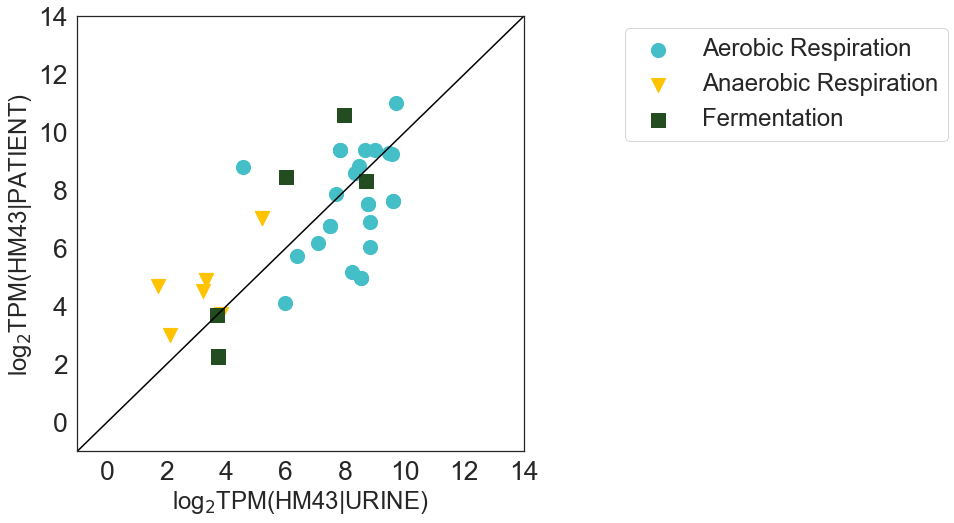

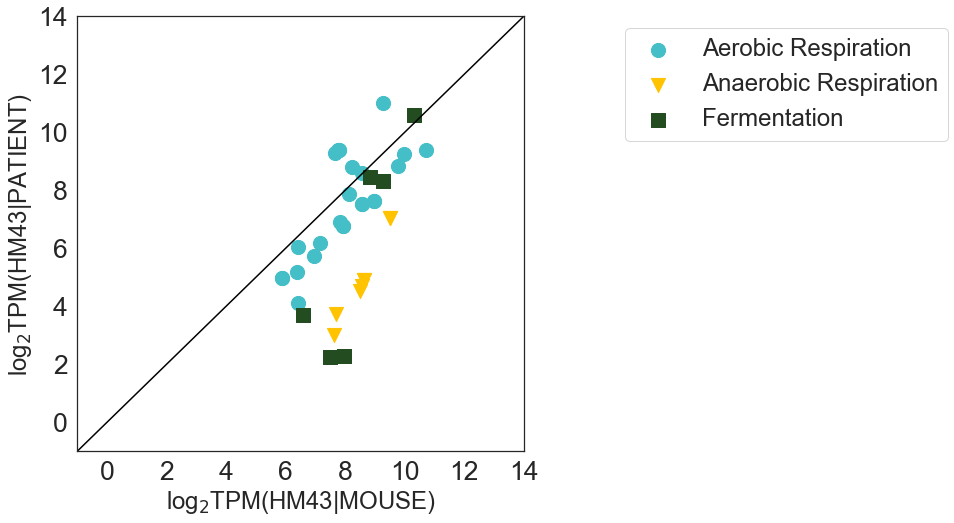

In [122]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism")

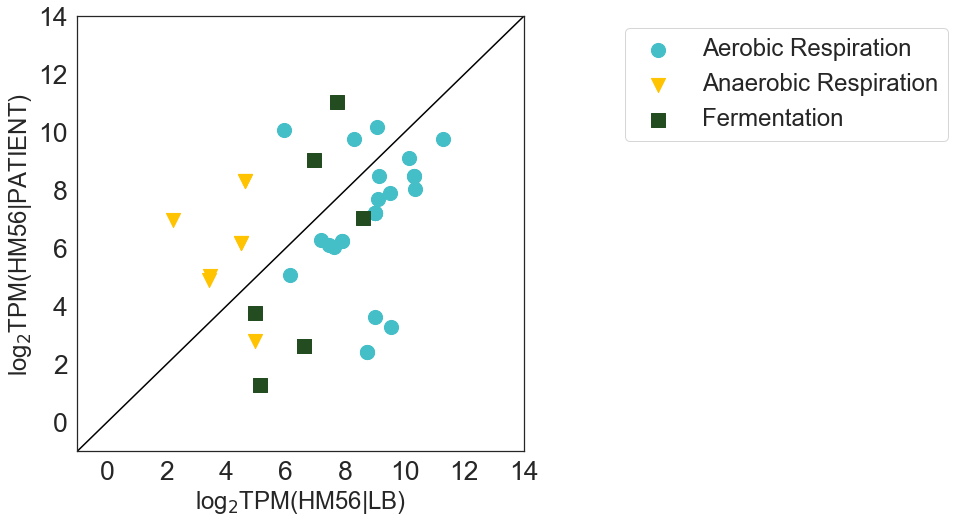

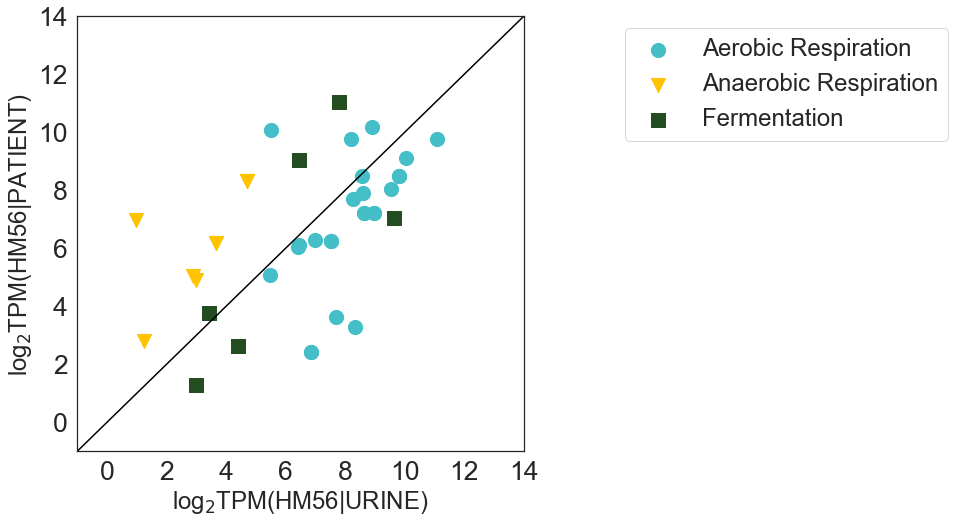

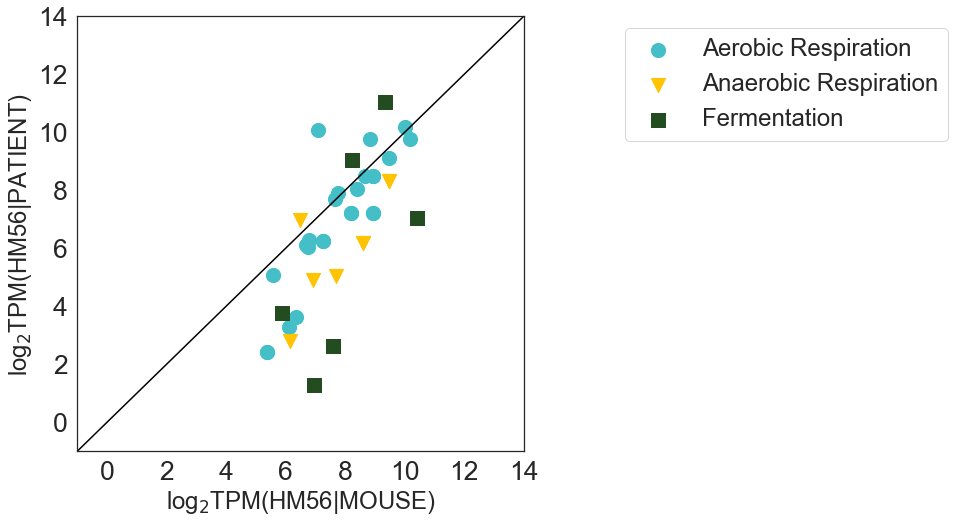

In [123]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism", conditions=cond2)

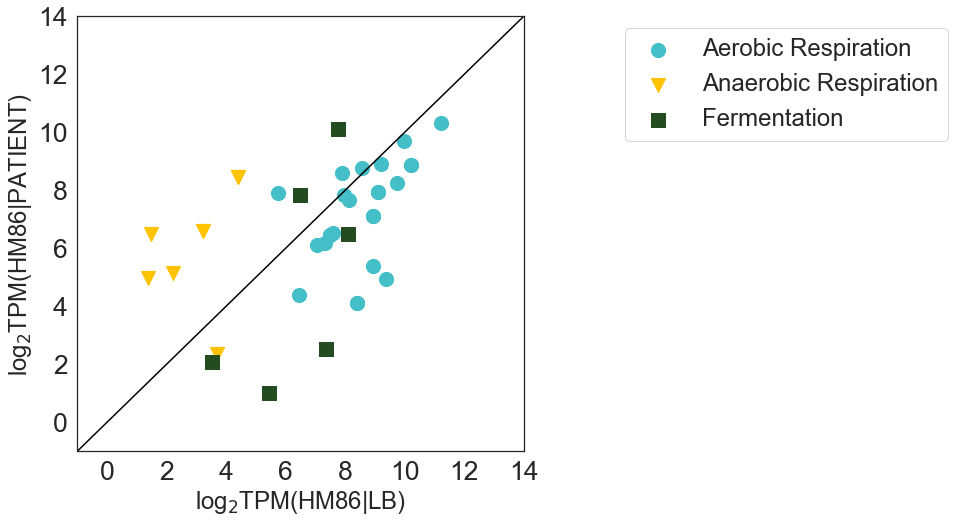

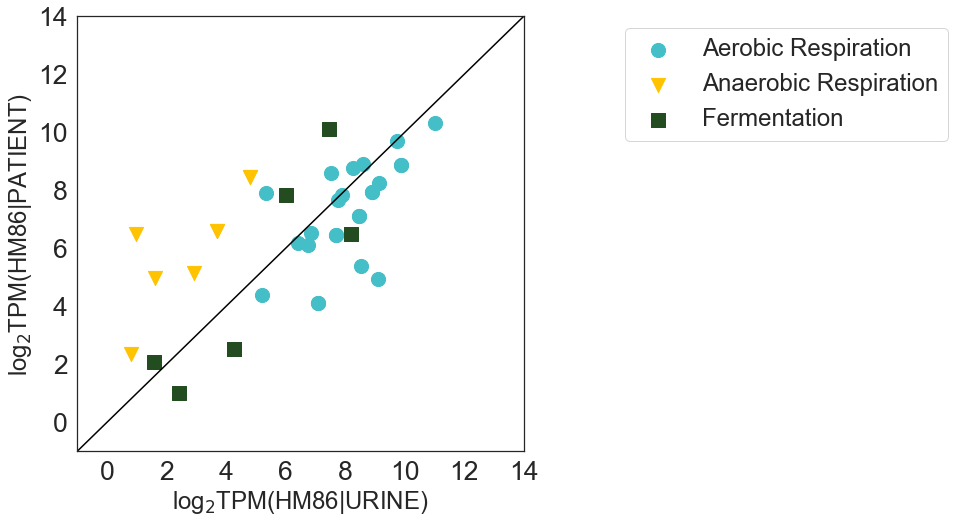

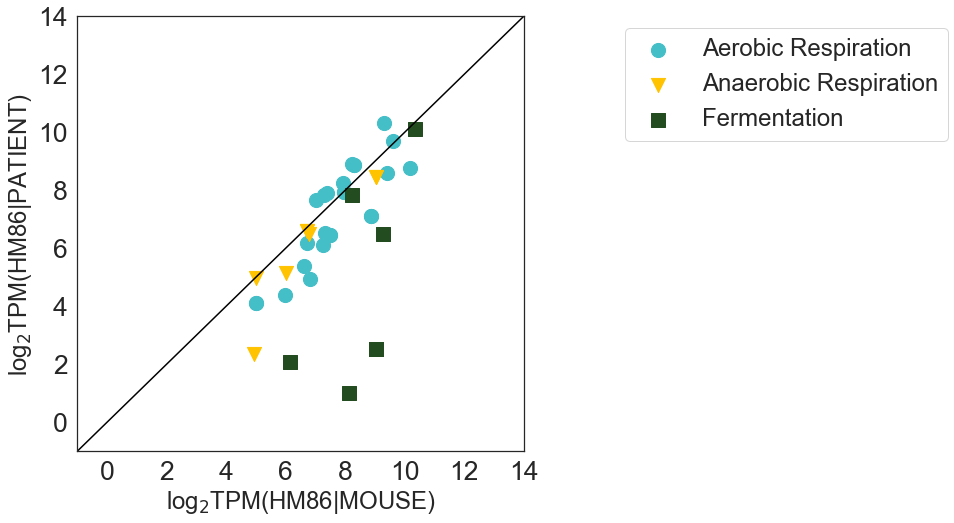

In [124]:
plot_functional_group(met_cnts, groupby="Function", group_alias="metabolism", conditions=cond3)

In [173]:
gene_sets = get_all_functional_groups(fgroups, orth_matrix)

In [179]:
def category_correlation(data, categories_table, pangenome, refs=["CFT073", "UTI89"]):
    subsets = []
   
    for ref in refs:
        if ref in categories_table.columns:
            names = list(categories_table[ref].dropna().index)
         
            lgenes = categories_table[ref].dropna().values
         
            df = pangenome[pangenome[ref].isin(lgenes)]
            subsets.append(df)
    fdf = pd.concat(subsets)
    t4 = data.loc[fdf.index]
    return fdf.merge(t4, left_index=True, right_index=True).drop_duplicates()

In [181]:
norm_cnts.head()

HM43_UTI  HM43_mouse   HM43_LB   HM43_UR   HM56_LB   HM56_UR  \
77094_rsxE  7.776148    6.862690  5.617974  4.767184  5.935038  6.455045   
78577_ispB  6.772067    6.875275  7.200546  6.899038  6.968896  6.653727   
77329_yebC  9.651185    9.696758  8.886417  8.083671  9.664517  8.805493   
76065_fepD  4.020953    4.832926  2.371523  3.864808  1.787837  3.471323   
77731_alaA  7.978817    7.585276  6.868173  6.429467  7.370914  7.540205   

            HM56_UTI  HM56_mouse   HM86_LB   HM86_UR  HM86_UTI  HM86_mouse  
77094_rsxE  7.245115    6.983785  6.737226  7.442731  7.487178    6.042873  
78577_ispB  7.008133    6.949147  6.724066  6.336856  6.899884    6.893135  
77329_yebC  9.747303    9.689878  9.593620  9.057696  9.659679    9.485485  
76065_fepD  4.492512    3.699829  1.302128  3.529695  4.163391    3.871928  
77731_alaA  7.170035    7.236809  7.679347  7.521189  7.399280    7.215174

['#03396c', '#6497b1', '#d3a625', '#ae0001']

In [186]:
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]
m_list = ['o', 'x', 'v', '*', 'p', 'h', 's','+', 8, '>']

df= category_correlation(norm_cnts, iron_df, pan43)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    #plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    for i, g in iron_df.groupby("Description"):
        plt.scatter(x[])
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())
    


KeyError: "None of [Index(['PROKKA_01397', 'PROKKA_00943', 'PROKKA_00949', 'PROKKA_00296',\n       'PROKKA_02729', 'PROKKA_02730', 'PROKKA_04034', 'PROKKA_01396',\n       'PROKKA_00725', 'PROKKA_02624', 'PROKKA_00946', 'PROKKA_00956',\n       'PROKKA_04258', 'PROKKA_02621', 'PROKKA_00440', 'PROKKA_01397',\n       'PROKKA_00943', 'PROKKA_00949', 'PROKKA_00942', 'PROKKA_00296',\n       'PROKKA_04257', 'PROKKA_02729', 'PROKKA_02620', 'PROKKA_02730',\n       'PROKKA_04034', 'PROKKA_01396', 'PROKKA_00944', 'PROKKA_04267',\n       'PROKKA_02624', 'PROKKA_00946', 'PROKKA_04261', 'PROKKA_00956',\n       'PROKKA_02621', 'PROKKA_00440'],\n      dtype='object', name='HM43')] are in the [index]"

In [183]:
pan43 = strain_pangenome(orth_matrix, "HM43")

Total Number of genes: 3817
Genes with no reference id: 365
Genes with only 1 id: 88
Genes with 5 ids: 2918


In [111]:
iron_df.head()

Functional Group    Description CFT073        UTI89          536  \
index                                                                     
FepA   Iron Acquisition          Other  c0669  UTI89_C0584  ECP_RS03065   
Iha    Iron Acquisition          Other  c3610          NaN          NaN   
IreA   Iron Acquisition          Other  c5174          NaN          NaN   
Fiu    Iron Acquisition          Other  c0890          NaN  ECP_RS04120   
CirA   Iron Acquisition  Enterobactin   c2690  UTI89_C2429          NaN   

               HM01          HM03          HM06          HM07          HM14  \
index                                                                         
FepA            NaN           NaN           NaN           NaN           NaN   
Iha             NaN           NaN           NaN           NaN           NaN   
IreA            NaN           NaN           NaN           NaN           NaN   
Fiu    PROKKA_00301  PROKKA_03767  PROKKA_04489  PROKKA_00067  PROKKA_00701   
CirA   PROKKA_01924  PROKKA_00513  PROKKA_00956  PROKKA_01741  PROKKA_02202   

               HM17          HM43          HM54          HM56          HM57  \
index                                                                         
FepA            NaN           NaN           NaN           NaN           NaN   
Iha             NaN           NaN           NaN           NaN           NaN   
IreA            NaN           NaN           NaN           NaN  PROKKA_03269   
Fiu    PROKKA_00948  PROKKA_00725  PROKKA_02554  PROKKA_03878  PROKKA_04487   
CirA   PROKKA_04375  PROKKA_04034  PROKKA_04187  PROKKA_02443  PROKKA_00990   

               HM60          HM68                       HM86  
index                                                         
FepA            NaN           NaN                        NaN  
Iha             NaN           NaN                        NaN  
IreA            NaN           NaN                        NaN  
Fiu    PROKKA_00575  PROKKA_00040               PROKKA_04112  
CirA   PROKKA_02485  PROKKA_01618  PROKKA_02517 PROKKA_02518

In [113]:
# Iron Acquisition
iron_df = gene_sets['Iron Acquisition']
iron_df.head()
t = (ut.get_tpms_for_prokkas(iron_df, norm_cnts1)
.merge(iron_df[["Functional Group", "Description"]], left_index = True, right_index=True))

In [115]:
t

HM43_UTI  HM43_mouse   HM43_LB    HM43_UR  HM56_UTI   HM56_LB  \
index                                                                   
ChuA         NaN         NaN       NaN        NaN       NaN       NaN   
ChuS   10.692962    9.339555  5.957267  10.191864  7.932575  6.411875   
CirA   10.521846    8.920523  4.058601   6.029927  7.888842  2.915058   
FeoA    7.935345    9.700388  7.075487   6.931175  7.637950  9.079357   
FeoB    6.134201    8.375905  5.392583   5.197382  6.064076  6.092795   
FepA         NaN         NaN       NaN        NaN       NaN       NaN   
FhuA         NaN         NaN       NaN        NaN       NaN       NaN   
FhuE    8.134790    6.512507  2.760573   6.816064  5.083374  2.069891   
Fiu     9.234258    4.983867  2.693211   3.285989  5.550674  5.557344   
FyuA   11.287699   10.030943  2.414401   8.307957  7.580225  1.703061   
Iha          NaN         NaN       NaN        NaN       NaN       NaN   
IreA         NaN         NaN       NaN        NaN       NaN       NaN   
IroB         NaN         NaN       NaN        NaN  7.406503  2.836444   
IroB         NaN         NaN       NaN        NaN  7.406503  2.836444   
IroB         NaN         NaN       NaN        NaN  6.886454  4.481099   
IroB         NaN         NaN       NaN        NaN  6.886454  4.481099   
IroC         NaN         NaN       NaN        NaN  6.369778  3.300545   
IroC         NaN         NaN       NaN        NaN  6.369778  3.300545   
IroC         NaN         NaN       NaN        NaN  7.061445  5.117282   
IroC         NaN         NaN       NaN        NaN  7.061445  5.117282   
IroD         NaN         NaN       NaN        NaN  7.061445  5.117282   
IroD         NaN         NaN       NaN        NaN  7.061445  5.117282   
IroD         NaN         NaN       NaN        NaN  6.369778  3.300545   
IroD         NaN         NaN       NaN        NaN  6.369778  3.300545   
IroN         NaN         NaN       NaN        NaN       NaN       NaN   
IucA         NaN         NaN       NaN        NaN       NaN       NaN   
IucB         NaN         NaN       NaN        NaN       NaN       NaN   
IucC         NaN         NaN       NaN        NaN       NaN       NaN   
IucD         NaN         NaN       NaN        NaN       NaN       NaN   
IutA         NaN         NaN       NaN        NaN       NaN       NaN   
...          ...         ...       ...        ...       ...       ...   
entA    8.935180    8.712676  4.459110   7.357662  6.381058  2.644339   
entB    9.150425    8.559863  4.304337   6.828344  6.991746  3.583070   
entC    7.761075    8.165340  4.307218   5.602631  7.088672  3.901528   
entD         NaN         NaN       NaN        NaN       NaN       NaN   
entE    6.435263    7.556065  1.104201   5.900225  4.650852  0.642871   
entE    6.435263    7.556065  1.104201   5.900225  4.650852  0.642871   
entE    8.829162    8.332498  4.209233   6.193001  7.145798  3.630415   
entE    8.829162    8.332498  4.209233   6.193001  7.145798  3.630415   
entF         NaN         NaN       NaN        NaN       NaN       NaN   
entS    6.378129    5.847311  3.992627   4.680904  5.379184  2.962385   
fes     8.112988    7.763720  3.959278   7.944115  6.761083  4.101198   
fhuC    7.265469    6.704352  4.801698   5.726464  7.189842  5.367572   
fhuD    5.973146    5.771843  3.620395   4.069348  6.152373  4.285487   
hma          NaN         NaN       NaN        NaN       NaN       NaN   
iroE         NaN         NaN       NaN        NaN  6.886454  4.481099   
iroE         NaN         NaN       NaN        NaN  6.886454  4.481099   
iroE         NaN         NaN       NaN        NaN  7.406503  2.836444   
iroE         NaN         NaN       NaN        NaN  7.406503  2.836444   
irp1    6.236899    7.932558  1.192094   5.629991  4.544337  0.360811   
irp2         NaN         NaN       NaN        NaN       NaN       NaN   
sitA         NaN         NaN       NaN        NaN       NaN       NaN   
sitB         NaN         NaN       NaN        NaN  8.491916  4.000

In [ ]:
norm_counts2.head()

In [ ]:
def expression_in_all_strains(group_df, strains, norm_counts, prefix="_UTI"):
    
    

In [ ]:
def graph_group_expression_by_description(group_df, strain1, strain2, norm_counts, prefix="_UTI", d="Description"):
    m_list = ['o', 'x', 'v', '*', 'p', 'h', 's','+', 8, '>']
  
    df = (two_strain_correlation((strain1, strain2), group_df, norm_counts, prefix, withna=True)
      .fillna(0)
      .merge(group_df, left_index=True, right_index=True))
    f = plt.figure(figsize=(12,12))
    if d:
        for i, group in enumerate(df.groupby(d)):
            x = group[1][strain1+prefix].values
            y = group[1][strain2+prefix].values

            plt.scatter(x,y, marker=m_list[i], s=300, label=group[0], alpha=0.8, )
            plt.xlabel("log2(TPM) {}".format(strain1), fontsize=20)
            plt.ylabel("log2(TPM) {}".format(strain2), fontsize=20)
            if group[0] == "Other":
                for i, txt in enumerate(group[1].index):
                    plt.gca().annotate(txt, (x[i], y[i]), xytext=(x[i]+0.3, y[i]), fontsize=16)

            plt.xlim(-1,14)
            plt.ylim(-1,14)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            plt.plot([-2, 20], [-2, 20], 'k-', linewidth=0.5)
            plt.legend(fontsize=16)
    else: 
        x = nor
    return f, df

f, d = graph_group_expression_by_description(iron_df, "HM43", "HM86", norm_counts2)
d.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
f, d = graph_group_expression_by_description(iron_df, "HM43", "HM86", unorm_counts2, prefix= "_UR")
d.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
f,g = graph_group_expression_by_description(iron_df, "HM43", "HM56", norm_counts2)
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
f,g = graph_group_expression_by_description(iron_df, "HM43", "HM56", unorm_counts2, prefix="_UR")
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
f,g = graph_group_expression_by_description(iron_df, "HM56", "HM86", norm_counts2)
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
f,g = graph_group_expression_by_description(iron_df, "HM56", "HM86", unorm_counts2, prefix="_UR")
g.iloc[:, 0:2].replace(0, np.nan).dropna().tail().corr()

In [ ]:
test = ic[["HM56_UTI", "Description"]]
test = test[test.HM56_UTI != 0]
test.Description.nunique()
#test = test[test.Description.isin(["Heme", "Salmochelin", "Enterobactin", "Yersinabactin", "Aerobactin"])]
test.Description.unique()

In [ ]:
def exprs_vs_redundancy(strains, matrix, cnts, prefix="_UTI", withna=False):
    s = []
    expr = []
    sch = []
    he = []
    nunq = []
    f = pd.DataFrame(index=matrix.index)
    for strain in strains:
        s.append(strain)
        strain_subset = pd.DataFrame()
     
        # Pick a random out of paralogs
        strain_subset[strain] = matrix[strain].str.split(" ", n=1, expand=True)[0]
       
        #two_strain_subset[strain2] = matrix[strain2].str.split(" ", n=1, expand=True)[0]# Randomly picks first of the paralogs
        if not withna:
            strain_subset = strain_subset.dropna()
            t = (strain_subset.join(cnts[strain+prefix],on=strain, how='left')
                .drop([strain], axis=1).merge(matrix, left_index=True, right_index=True))
            #t = t[t.Description.isin(["Fhu Operon","Sit Operon",
             #                         "Heme", "Salmochelin ", "Enterobactin", "Yersinabactin", "Aerobactin", "Other"])]
            f = f.merge(pd.DataFrame(t[strain+prefix]), how='outer', left_index=True, right_index=True)
            expr.append(t[strain+prefix].mean())
            he.append(t[t.Description == "Heme"][strain+prefix].mean())
            sch.append(t[t.Description == "Salmochelin "][strain+prefix].mean())
            nunq.append("Aerobactin" in list(t["Description"].unique()))
            #nunq.append(t["Description"].nunique())
        else:
            pass
    return pd.DataFrame({"Expr":expr, "nunq":nunq, "Heme":he, 'sch':sch}, index=s), f
       
    

#df, f = exprs_vs_redundancy(strains, iron_df, norm_counts2, )


#df2 = two_strain_correlation(("HM43", "HM56"), core, uncnts, "_UR" )

In [ ]:
def get_expression(matrix, strains, counts, prefix="_UTI"):
    d = matrix[strains].T.to_dict()
    nd = {}
    for gene, strain_dict in d.items():
        nd[gene] = {}
        for k,v in strain_dict.items():
            if v is np.nan:
                expr = np.nan
            elif len(v.split())>1:
                expr = np.nan
            else:
                expr = counts.loc[v][k+prefix]
            nd[gene][k] = expr
    df = pd.DataFrame(nd).T
    return df

#x = get_expression(iron_df, strains, norm_counts2)
#x = x.merge(iron_df[['Functional Group', "Description"]], how='outer', left_index=True, right_index=True)
    #print(counts[[c+prefix for c in strains]].head())

In [ ]:
x = x.reset_index()
y = pd.melt(x, id_vars=['index', 'Description'], value_vars=strains, value_name='Expr')


In [ ]:
plt.figure(figsize=(30,20))
sns.boxplot(x='Description', y='Expr', hue='variable', data=y)
plt.plot((0.5,0.5), (0.5, 10), 'k--', linewidth=3)
plt.plot((1.5,1.5), (0.5, 10), 'k--', linewidth=3)

In [ ]:
df

In [ ]:
# Effect of aerobaction on iron system expression

sns.boxplot(x='nunq', y='Expr', data=df)

In [ ]:
plt.scatter(df.nunq, df.Expr)
pearsonr(df.nunq, df.Expr)

In [ ]:
x = gene_sets['motility'].drop_duplicates()
y = x[['HM43', 'HM56']].dropna()
z1 = norm_counts.loc[y.HM43.values]['HM43_UTI']
z2 = norm_counts.loc[y.HM56.values]["HM56_UTI"]
plt.xlim(-2.5,1)
plt.ylim(-2.5, 1)
plt.scatter(z1, z2)

In [ ]:
# Adhesion
ad_df = gene_sets['adherence']
ad_df.Description.nunique()

In [ ]:
f, d = graph_group_expression_by_description(ad_df, "HM43", "HM86", norm_counts2)


In [ ]:
ad_df

In [ ]:
f, d = graph_group_expression_by_description(ad_df, "HM43", "HM56", norm_counts2)
plt.plot((0,0), (0,14), "k-")
plt.plot((14,0), (0,0), 'k-')

In [ ]:
f, d = graph_group_expression_by_description(ad_df, "HM56", "HM86", norm_counts2)

In [ ]:
fgroups['Functional Group'].unique()

In [ ]:
mot_df = gene_sets['motility']
mot_expr = get_expression(mot_df, strains, norm_counts2, prefix="_UTI")

mot_expr.head()

In [ ]:
mot_expr = mot_expr.reset_index()
mot_expr = pd.melt(mot_expr, id_vars=['index'], value_vars=strains, value_name='Expr')


In [ ]:
mot_expr = mot_expr.sort_values('Expr')

In [ ]:
fim_genes = 'c5393 c5394 c5395 c5396 c5397 c5399'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]

In [ ]:
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')

In [ ]:
plt.figure(figsize=(20,10))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
plt.title("Fim genes", fontsize=24)
plt.ylabel("log2(TPM)", fontsize=24)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
t = fim_expr.mean()

In [ ]:
#Flagella
fim_genes = "c1342 c1343 c1344 c1345 c1346 c1347 c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,10))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
plt.title("Flagella genes", fontsize=24)
plt.ylabel("log2(TPM)", fontsize=24)
plt.xlabel("")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
# flg in ur
fim_genes = "c1342 c1343 c1344 c1345 c1346 c1347 c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, unorm_counts2, prefix="_UR").reset_index()
flg = fim_expr.mean()

fim_genes = 'c5393 c5394 c5395 c5396 c5397 c5399'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, unorm_counts2, prefix="_UR").reset_index()
fim = fim_expr.mean()
plt.figure(figsize=(6,6))

q2 = pd.DataFrame([fim, flg], index=('fim', 'flg')).T
plt.scatter(q2.fim, q2.flg, color='grey', s=250)
plt.plot((6.6,6.6), (0,14), 'k--')
#plt.plot((9.96,9.96), (0,14), 'k--')
#plt.plot((0,14), (9.96,9.96), 'k--')
plt.plot((0,14), (7,7), 'k--')
plt.ylim(0,12)
plt.xlim(0,12)
plt.ylabel("log2(TPM) flagella", fontsize=24)
plt.xlabel("log2(TPM) fim", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [ ]:
s = fim_expr.mean()

In [ ]:
q

In [ ]:
q = pd.DataFrame([t, s], index=['Fim', 'Flagella']).T
plt.figure(figsize=(6,6))
plt.scatter(q.Fim, q.Flagella, color='blue', s=250)
plt.plot((6.6,6.6), (0,14), 'k--')
#plt.plot((9.96,9.96), (0,14), 'k--')
plt.plot((0,14), (6.6,6.6), 'k--')
#plt.plot((0,14), (9.96,9.96), 'k--')
#plt.plot(7.5,4.3, 'ro', markersize=15, label='LB')
#plt.plot(6.9,2.5, 'ko', markersize=15, label='UR')
#plt.plot(10.6,3.7, 'go', markersize=15, label='UTI')
plt.ylim(0,12)
plt.xlim(0,12)
plt.ylabel("log2(TPM) flagella", fontsize=24)
plt.xlabel("log2(TPM) fim", fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

q

In [ ]:
last=q.merge(q2, left_index=True, right_index=True).dropna()
last.columns = ['fim_uti', 'flg_uti', 'fim_ur', 'flg_ur']
last
plt.figure(figsize=(10,10))
x = last.fim_ur.values
y = last.flg_ur.values
w = last.fim_uti.values
z = last.flg_uti.values
plt.scatter(last.fim_ur, last.flg_ur, color='red')
plt.scatter(last.fim_uti, last.flg_uti, color='black')
for i, txt in enumerate(last.index):
    plt.annotate( txt, (x[i], y[i]),)
    plt.annotate(txt, (w[i], z[i]))

In [ ]:
fim_genes = "c2336 c2337 c2353 c2354 c2355 c2357 c2358 c2359 c2360 c2361 c2362 c2363 c2364 c2365".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,20))
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))

In [ ]:
#Iron
fim_genes = 'c0890 c2690 c2433 c3625 c3627 c4308 c0682 c0680 c0668'.split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
plt.figure(figsize=(20,20))
#sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
X = x.sort_values('Expr').variable.values

Y = x.sort_values('Expr').Expr.values
sns.boxplot(x='variable', y='Expr', data=x.sort_values('Expr'))
sns.swarmplot(x='variable', y='Expr', data=x.sort_values('Expr'), color='black', size=12)

In [ ]:

for i,g in x.groupby('index'):
    plt.figure(figsize=(8,6))
    s =sns.barplot(x='variable', y='Expr', data=g.sort_values('Expr'))
    plt.xlabel(i)

In [ ]:
fim_genes = "c1099 c5029 c3424 c4824 c2714 c5296 c1981 c2717 c2543".split()
fim_df = orth_matrix[orth_matrix['CFT073'].isin(fim_genes)]
fim_expr = get_expression(fim_df, strains, norm_counts2, prefix="_UTI").reset_index()
x = pd.melt(fim_expr, id_vars=['index'], value_vars=strains, value_name='Expr')
for i,g in x.groupby('index'):
    plt.figure(figsize=(8,6))
    s =sns.barplot(x='variable', y='Expr', data=g.sort_values('Expr'))
    plt.xlabel(i)

In [ ]:
mot_expr[mot_expr['index']=="flgG"]

In [ ]:
plt.figure(figsize=(20,20))
sns.boxplot(x='variable', y='Expr', data=mot_expr)
#plt.plot((0.5,0.5), (0.5, 10), 'k--', linewidth=3)
#plt.plot((1.5,1.5), (0.5, 10), 'k--', linewidth=3)

In [ ]:
f, d = graph_group_expression_by_description(mot_df, "HM43", "HM56", norm_counts2)

In [ ]:
f, d = graph_group_expression_by_description(mot_df, "HM43", "HM86", norm_counts2)

In [ ]:
x = test_matrix.join(functions[functions.genome == "UTI89"], on='UTI89')
x[x.UTI89 == "UTI89_C5035"]

In [ ]:
functions.genome


In [ ]:
for name, g in functions.groupby(['function','genome']):
    function = name[0]
    genome = name[1]
    genes = g.index
    
    print(name)
    #df = matrix[matrix[genome].isin(genes)].join(g['gene'], on=genome, how='left')
    
    


In [ ]:
df

In [ ]:
df

In [ ]:
[c for c in matrix.index if 'fim' in c]

In [ ]:
matrix[matrix["HM03"] == "PROKKA_02808"]

In [ ]:
pa_table

In [ ]:
matrix.head()

In [ ]:
pa_table = pd.read_csv(pa_path, index_col = 0)

In [ ]:
pa_table.replace('0', np.nan, inplace=True)

In [ ]:
pa_table

In [ ]:
iron = functions[functions.function == "Adhesins"].iloc[:-1,:]

In [ ]:
iron

In [ ]:
t = pd.merge(iron[['gene']], pa_table, how="left", left_index=True, right_index=True).set_index(["gene"])

In [ ]:
f = t.T.to_dict()

In [ ]:
f['aufA']['HM01'] is np.nan

In [ ]:
cnts["HM17_UTI"]["PROKKA_02993"]

In [ ]:
def get_counts_for_matrix(matrix, cnts_dict):
    f = matrix.T.to_dict()
    fd = {}
    for gene, strain_dict in f.items():
        for strain, prk in strain_dict.items():
            if prk is np.nan :
                c = prk
            elif prk == "PARALOGS":
                c = np.nan
            else:
                c = cnts[strain +"_UTI"][prk]
            if gene in fd.keys():
                fd[gene][strain] = c
            else:
                fd[gene] = {strain:c}
    return pd.DataFrame(fd).T

In [ ]:
var_counts = get_counts_for_matrix(variable, cnts)
var_counts.head()

In [ ]:
var_counts.T.std().describe()

In [ ]:
core_counts =  get_counts_for_matrix(core, cnts)
core_counts.T.std().hist()

In [ ]:
core_counts.T.std().hist(bins = 30, alpha=0.8)
var_counts.T.std().hist(bins = 30, alpha=0.6)

In [ ]:
var_counts.isnull().sum(axis=1)


In [ ]:
d

In [ ]:
df = pd.DataFrame(fd).T
df.loc['fimH'].std()

In [ ]:
variable.head()

In [ ]:
x, y = correlation_two_strains(t, tpms, ("HM17", "HM43"))
w,z = correlation_two_strains(t, tpms, ("HM54", "HM06"))

In [ ]:
plt.scatter(x,y)
#plt.scatter(w,z)

In [ ]:
functions

In [ ]:
l = [ c for c in orth_matrix.index if 'fim' in c]

In [ ]:
orth_matrix.loc[l].HM14.dropna()

['76009_fimZ','26581_fimD_2', '8832_fimA_3', '26582_fimD_3']

In [ ]:
df = (two_strain_correlation(("HM43", "HM14"), orth_matrix, norm_counts)
      .fillna(0)
      .merge(orth_matrix, left_index=True, right_index=True))

In [ ]:
?plt.scatter

In [ ]:
plt.scatter(df.HM43_UTI[0:100], df.HM14_UTI[0:100], color='black', )
plt.plot(data.HM43_UTI, test_result.predict(), color='red')

In [ ]:
def get_residuals(x, y, data, pg = orth_matrix, rg = ref_genomes, th=2, gene_info=''):
    genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}
    model = sm.OLS.from_formula("{} ~ {}".format(y, x), data=data)# ordinary least squares
    result = model.fit()
    print(result.params)
    residuals = result.resid
    threshold = result.resid.std()*th

    outliers = pd.DataFrame(result.resid[abs(result.resid)> threshold])
    out_df = pg.join(outliers,how='right').rename(columns={0:'Residual'})
    out_df = out_df.dropna(subset=rg, how='all')
    outliers_dict = out_df.T.to_dict()
    if not gene_info:
        gene_info = get_gene_info_from_dict(outliers_dict)
    elif gene_info == 'ignore':
        return out_df, result
    gene_info_df = pd.DataFrame(gene_info).T
    gene_info_df.columns = ["Gene Name", "Description"]
    out_df = out_df.merge(gene_info_df, left_index=True, right_index=True).sort_values(['Residual'])
    return out_df, result
#LB_outliers, LB_result  = get_residuals('HM43_LB', 'HM43_UTI', cnts, gene_info='ignore')

In [ ]:
def plot_residuals(result,  th=2):   
    fig = plt.figure(figsize=(10,8))
    threshold = th*result.resid.std()
    plt.axhline(threshold, color='black', linewidth=0.5)
    plt.axhline(-threshold, color='black', linewidth=0.5)
    plt.scatter(result.predict(), result.resid, edgecolors='white', color='black', s=80)
    plt.ylabel("Residuals", fontsize=20)
    plt.xlabel("Predicted gene expression", fontsize=20)
    return fig

In [ ]:
data = df[["HM43_UTI", "HM14_UTI"]].iloc[:100,]

In [ ]:
test_out, test_result = get_residuals('HM43_UTI', 'HM14_UTI', data, gene_info='ignore')

In [ ]:
f = plot_residuals(test_result)
plt.plot((-10,30), (0,0), color='red')
plt.xlim(-1.5, 2.5)

In [ ]:
dir(test_result)

### Mouse RNA seq data analysis: exploratory

* Look at correlation between replicates/conditions
* PCA

In [ ]:
def get_gene_info_from_dict(outliers_dict):
    gene_info = {}
    for key, val in outliers_dict.items():
        gene_info[key] = ('', '')
        for ref in reference_genomes:
            if val[ref] is np.nan:
                continue
            else:
                gene_id = '{}:{}'.format(genome_abbr[ref], val[ref])
                gene = Gene(gene_id)
                gene.kegg_get()
                _, gene_name, description = gene.get_short_info().split('\t')
                if gene_name or description:
                    gene_info[key] = (gene_name, description)
                    break
    return gene_info

In [ ]:
# Set porper paths
raw_counts_dir = "/Users/annasintsova/git_repos/mouse_model/data/raw_count"
out_dir = "/Users/annasintsova/git_repos/mouse_model/results/"
gff = "/Users/annasintsova/git_repos/HUTI-RNAseq/data/annotations/gff_files/HM43.gff"

fig_dir = "/Users/annasintsova/git_repos/mouse_model/figures"
cols = ["#0084ff", "#44bec7", "#ffc300", "#fa3c4c", "#d696bb"]
pangenome_path = "/Users/annasintsova/git_repos/mouse_model/results/find_pangenome/pangenome.csv"
pangenome_OMCL_path = "/Users/annasintsova/git_repos/mouse_model/results/find_pangenome/pangenome_OMCL.csv"
reference_genomes = ['K-12', 'CFT073', 'UTI89', 'UMN026', '536']

In [ ]:

#crp_path = "/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/crp_genes.csv"
#ribo_path = "/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/ribo_genes.csv"

In [ ]:
# Convert raw counts to TPMs
# raw_counts_dir has count data for one strain (ex. HM43)


In [ ]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("LB", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.82", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
#s.savefig(Path(fig_dir).joinpath("LB_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [ ]:
def get_residuals(x, y, data, pg = panHM43_OMCL, rg = reference_genomes, th=2, gene_info=''):
    genome_abbr = {'UTI89':'eci', 'K-12':'eco', 'CFT073':'ecc', '536':'ecp', 'UMN026':'eum'}
    model = sm.OLS.from_formula("{} ~ {}".format(y, x), data=data)# ordinary least squares
    result = model.fit()
    print(result.params)
    residuals = result.resid
    threshold = result.resid.std()*th

    outliers = pd.DataFrame(result.resid[abs(result.resid)> threshold])
    out_df = pg.join(outliers,how='right').rename(columns={0:'Residual'})
    out_df = out_df.dropna(subset=rg, how='all')
    outliers_dict = out_df.T.to_dict()
    if not gene_info:
        gene_info = get_gene_info_from_dict(outliers_dict)
    elif gene_info == 'ignore':
        return out_df, result
    gene_info_df = pd.DataFrame(gene_info).T
    gene_info_df.columns = ["Gene Name", "Description"]
    out_df = out_df.merge(gene_info_df, left_index=True, right_index=True).sort_values(['Residual'])
    return out_df, result
LB_outliers, LB_result  = get_residuals('HM43_LB', 'HM43_UTI', cnts, gene_info='ignore')

In [ ]:
def plot_residuals(result,  th=2):   
    fig = plt.figure(figsize=(10,8))
    threshold = th*result.resid.std()
    plt.axhline(threshold, color='black', linewidth=0.5)
    plt.axhline(-threshold, color='black', linewidth=0.5)
    plt.scatter(result.predict(), result.resid, color=cols[3], edgecolors='white')
    plt.ylabel("Residuals", fontsize=20)
    plt.xlabel("Predicted gene expression", fontsize=20)
    return fig

g = plot_residuals(LB_result)
plt.ylim(-3.5,3.5)
#g.savefig(Path(fig_dir).joinpath("LB_residuals.png"), dpi=150, bbox_inches="tight")

In [ ]:
LB_result.resid.hist(bins=50)

In [ ]:
###
out_df.to_csv(Path(out_dir)/"LB_outliers.csv")

In [ ]:
s = sns.jointplot( x = "HM43_UR", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("URINE", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.78", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("UR_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [ ]:
urine_outliers, urine_result = get_residuals('HM43_UR', 'HM43_UTI', cnts, th=2, gene_info='ignore')

In [ ]:
###
urine_outliers.to_csv(Path(out_dir)/"UR_outliers.csv")

In [ ]:
urine_result.resid.hist(bins=50)

In [ ]:
g = plot_residuals(urine_result)
plt.ylim(-3.5,3.5)
g.savefig(Path(fig_dir).joinpath("Urine_residuals.png"), dpi=150, bbox_inches="tight")

In [ ]:
s = sns.jointplot( x = "HM43_mouse", y ="HM43_UTI", data=cnts, color = 'black', alpha=0.4, height=6)
s.set_axis_labels("MOUSE", "PATIENT", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.88", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("Mouse_vs_UTI.png"), dpi=150, bbox_inches="tight")

In [ ]:
mouse_outliers, mouse_result = get_residuals('HM43_mouse', 'HM43_UTI', cnts, th=2, gene_info='ignore')

In [ ]:
###
mouse_outliers.to_csv(Path(out_dir)/'Mouse_outliers.csv')


In [ ]:
g = plot_residuals(mouse_result)
plt.ylim(-3.5,3.5)
g.savefig(Path(fig_dir).joinpath("Mouse_residuals.png"), dpi=150, bbox_inches="tight")

In [ ]:
logTPM = np.log2(tpm_df +1)
logTPM['HM43_LB'] = logTPM[["HM43_LB_rep1", "HM43_LB_rep2"]].mean(axis=1)
logTPM['HM43_UR'] = logTPM[["HM43_UR_rep1", "HM43_UR_rep2"]].mean(axis=1)
logTPM = logTPM[["HM43_LB", "HM43_UR", "HM43_mouse", "HM43_UTI"]]
logTPM.corr().round(2)

In [ ]:
### Don't really need this


plt.figure(figsize=(20,20))

s = sns.jointplot( x = "HM43_LB", y ="HM43_mouse", data=cnts, color = 'black', alpha=0.4, height=8)
s.set_axis_labels("LB", "MOUSE", fontsize=20)
s.fig.text(0.2, 0.75, "r = 0.78", horizontalalignment='left', fontsize=20, color='black', weight='semibold')
s.savefig(Path(fig_dir).joinpath("LB_vs_MOUSE.png"), dpi=150, bbox_inches="tight")

In [ ]:
def find_pc1_pc2(df, meta):
    df = df.T
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    pDf = (pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
           .set_index(df.index))
    pc1_var = round(pca.explained_variance_ratio_[0] * 100, 2)
    pc2_var = round(pca.explained_variance_ratio_[1] * 100, 2)
    pDf2 = pDf.merge(meta, left_index=True, right_index=True)
    return pDf2, pc1_var, pc2_var


def plotPCA(pDf, pc1_var, pc2_var, colorby, col, nameby="", el=False): 
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=2.2)
    group = pDf[colorby].unique()
    assert len(group) <= len(col)
    fig = plt.figure(figsize=(8, 8))
    for g, c in zip(group, col):
        df = pDf[pDf[colorby] == g]
        x, y = df[["PC1"]].values, df[["PC2"]].values
        ax = plt.scatter(x, y, c=c, s=150, label=g)  
        if el:
            pts = np.asarray([[float(a), float(b)] for a, b in zip(x, y)])
            plot_point_cov(pts, nstd=2, alpha=0.1, color=c)
        if nameby:
            labels = df[nameby]
            for label, pc1, pc2 in zip(labels, x, y):
                plt.annotate(label, xy=(pc1, pc2), xytext=(-5, 7), textcoords="offset points",fontsize=14)
        plt.xlabel('Principal Component 1, {} %'.format(pc1_var), )
        plt.ylabel('Principal Component 2, {} %'.format(pc2_var), )
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.legend(fontsize=16, frameon=True)
    return fig

In [ ]:
norm_cnts.head()

In [ ]:
strain_info = pd.DataFrame([c.split("_")[1] for c in norm_cnts.columns], index = norm_cnts.columns, columns=["condition"])

In [ ]:
strain_info

In [ ]:
pDf, pc1, pc2 = find_pc1_pc2(norm_cnts, strain_info)

In [ ]:
pc2

In [ ]:
f = plotPCA(pDf, pc1, pc2, "condition", col=cols, nameby="", el=False)
f.savefig(Path(fig_dir).joinpath("PCA.png"), dpi=150, bbox_inches="tight")

In [ ]:
os.listdir(raw_counts_dir)

In [ ]:
raw_counts = {}
for f in os.listdir(raw_counts_dir):
    if f.endswith('txt'):
        raw_counts[f.split('_trimmed')[0]] = process_counts.process_count_file(os.path.join(raw_counts_dir,f))
        
cnts = pd.DataFrame(raw_counts)
cnts.to_csv("/Users/annasintsova/git_repos/HUTI-RNAseq/shared_data/mouse_lb_raw_counts.csv")

In [ ]:
hm43_core = pd.merge(cnts, HM43_ortho, left_index=True, right_on="HM43").iloc[:,:-1]

In [ ]:
# Functional Catergories

In [ ]:
orth_matrix = pd.read_csv(pangenome_file, index_col=0)
print(orth_matrix.shape) # 15420, 20
tpms = process_counts.normalize_counts_to_tpm(raw_counts_dir, gff_dir, results_dir)
counts = pd.DataFrame(tpms)
pcounts = counts[[c for c in counts.columns if "UTI" in c and 'seq' not in c]]
urine_counts = counts[[c for c in counts.columns if 'UR' in c and 'seq' not in c]]
uncnts = urine_counts.apply(ut.invnorm)
norm_counts = pcounts.apply(ut.invnorm)

In [ ]:
norm_counts2 = np.log2(pcounts+1)
unorm_counts2 = np.log2(urine_counts+1)

In [100]:
fgroups = pd.read_csv(functional_groups_file, index_col=0)
to_keep = ['Functional Group', "Description", "CFT073", "UTI89", "536"]
fgroups = fgroups[to_keep]
strains = "HM01 HM03 HM06 HM07 HM14 HM17 HM43 HM54 HM56 HM57 HM60 HM68 HM86".split()

def get_category_genes(fgroup, panmatrix, refs, strains=strains):
    subsets = []
    for ref in refs:
        if ref in fgroup.columns:
            ref_df = fgroup.dropna(subset=[ref]).reset_index()
            
            ref_df = ref_df.merge(panmatrix[strains+[ref]], how='left', left_on = ref, right_on=ref)
            subsets.append(ref_df)            
    fdf = pd.concat(subsets, sort=False).drop_duplicates().set_index('index')
    return fdf


def get_all_functional_groups(fgroups, panmatrix, refs=['CFT073', 'UTI89'], function='Functional Group', description='Description' ):
    gene_sets = {}
    for i, g in fgroups.groupby(function):
        fdf  = get_category_genes(g, panmatrix, refs ) 
        gene_sets[i] = fdf
    return gene_sets
    
    
    
gene_sets = get_all_functional_groups(fgroups, orth_matrix)    

In [105]:
nc86.head()

HM86_LB   HM86_UR  HM86_UTI  HM86_mouse
PROKKA_00001      0.0  0.000000       0.0         0.0
PROKKA_00002      0.0  0.000000       0.0         0.0
PROKKA_00003      0.0  0.113783       0.0         0.0
PROKKA_00004      0.0  0.000000       0.0         0.0
PROKKA_00005      0.0  0.000000       0.0         0.0

In [104]:
t = ut.get_tpms_for_prokkas(gene_sets['Iron Acquisition'], 

Functional Group           Description    CFT073         UTI89  \
index                                                                   
FepA   Iron Acquisition                 Other     c0669   UTI89_C0584   
Iha    Iron Acquisition                 Other     c3610           NaN   
IreA   Iron Acquisition                 Other     c5174           NaN   
Fiu    Iron Acquisition                 Other     c0890           NaN   
CirA   Iron Acquisition         Enterobactin      c2690   UTI89_C2429   
fes    Iron Acquisition         Enterobactin      c0671   UTI89_C0586   
entS   Iron Acquisition         Enterobactin      c0678   UTI89_C0593   
entB   Iron Acquisition         Enterobactin      c0682   UTI89_C0597   
entC   Iron Acquisition         Enterobactin      c0680   UTI89_C0595   
entD   Iron Acquisition         Enterobactin      c0668   UTI89_C0583   
entE   Iron Acquisition         Enterobactin      c2433   UTI89_C0596   
entF   Iron Acquisition         Enterobactin      c0673   UTI89_C0588   
IroN   Iron Acquisition          Salmochelin      c1250   UTI89_C1118   
IroB   Iron Acquisition          Salmochelin      c1254   UTI89_C1119   
IroC   Iron Acquisition          Salmochelin      c1253   UTI89_C1120   
IroD   Iron Acquisition          Salmochelin      c1252   UTI89_C1121   
iroE   Iron Acquisition          Salmochelin      c1251   UTI89_C1122   
IutA   Iron Acquisition            Aerobactin     c3623           NaN   
IucA   Iron Acquisition            Aerobactin     c3627           NaN   
IucB   Iron Acquisition            Aerobactin     c3626           NaN   
IucC   Iron Acquisition            Aerobactin     c3625           NaN   
IucD   Iron Acquisition            Aerobactin     c3624           NaN   
hma    Iron Acquisition                  Heme     c2482   UTI89_C2234   
ChuA   Iron Acquisition                  Heme     c4308   UTI89_C4028   
ChuS   Iron Acquisition                  Heme     c4307   UTI89_C4027   
chuT   Iron Acquisition                  Heme     c4313   UTI89_C4033   
chuW   Iron Acquisition                  Heme     c4314   UTI89_C4034   
chuX   Iron Acquisition                  Heme  c4315      UTI89_C4035   
chuY   Iron Acquisition                  Heme     c4316   UTI89_C4036   
chuU   Iron Acquisition                  Heme     c4317   UTI89_C4037   
sitA   Iron Acquisition            Sit Operon     c1600   UTI89_C1339   
sitB   Iron Acquisition            Sit Operon     c1599   UTI89_C1338   
sitC   Iron Acquisition            Sit Operon     c1598   UTI89_C1337   
sitD   Iron Acquisition            Sit Operon     c1597   UTI89_C1336   
fhuD   Iron Acquisition            Fhu Operon     c0187   UTI89_C0168   
fhuC   Iron Acquisition            Fhu Operon     c0186   UTI89_C0167   
FhuA   Iron Acquisition            Fhu Operon     c0185   UTI89_C0166   
FhuE   Iron Acquisition            Fhu Operon     c1374   UTI89_C1229   
FeoA   Iron Acquisition  Feo iron transporter     c4185   UTI89_C3909   
FeoB   Iron Acquisition  Feo iron transporter     c4186   UTI89_C3910   
tonB   Iron Acquisition                 Other     c1717   UTI89_C1451   
entA   Iron Acquisition         Enterobactin        NaN   UTI89_C0598   
entE   Iron Acquisition         Enterobactin      c2433   UTI89_C0596   
IroB   Iron Acquisition          Salmochelin      c1254   UTI89_C1119   
IroC   Iron Acquisition          Salmochelin      c1253   UTI89_C1120   
IroD   Iron Acquisition          Salmochelin      c1252   UTI89_C1121   
iroE   Iron Acquisition          Salmochelin      c1251   UTI89_C1122   
FyuA   Iron Acquisition         Yersinabactin       NaN   UTI89_C2188   
ybtQ   Iron Acquisition         Yersinabactin       NaN   UTI89_C2180   
ybtP   Iron Acquisition         Yersinabactin       NaN  UTI89_C2181    
irp2   Iron Acquisition         Yersinabactin       NaN   UTI89_C2183   
irp1   Iron Acquisition         Yersinabactin       NaN   UTI89_C2184   
ybtU   Iron Acquisition         Yersinabactin       NaN  UTI89_C2

In [ ]:
categories = (pd.read_csv("/Users/annasintsova/git_repos/mouse_model/data/functional_categories.csv")
              .drop(['Unnamed: 7', 'Unnamed: 8'], axis=1))

In [ ]:
categories.at[35, 'CFT073'] = 'c1646'

In [122]:
def category_correlation(data, categories_table, pangenome, refs=reference_genomes ):
    subsets = []
   
    for ref in refs:
        if ref in categories_table.columns:
            names = list(categories_table[ref].dropna().index)
         
            lgenes = categories_table[ref].dropna().values
         
            df = pangenome[pangenome[ref].isin(lgenes)]
            subsets.append(df)
    fdf = pd.concat(subsets)
    t4 = data.loc[fdf.index]
    return fdf.merge(t4, left_index=True, right_index=True).drop_duplicates()

NameError: name 'reference_genomes' is not defined

In [ ]:
df.head()

In [ ]:
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

df= category_correlation(logTPM, iron_df, panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())


In [ ]:
fgroups

In [ ]:
df= category_correlation(logTPM, gene_sets['adherence'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())

In [121]:
gsets2 = get_all_functional_groups(fgroups,orth_matrix, function='Description', description='Description' )


NameError: name 'get_all_functional_groups' is not defined

In [ ]:
for g in gsets2.keys():
    print(g)

In [ ]:
df1= category_correlation(logTPM, gsets2['fim'], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['auf'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['yeh'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['yfc'], panHM43_OMCL, reference_genomes)
df5 = category_correlation(logTPM, gsets2['curli biogenesis'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='fim', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='auf', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='yeh', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[1], label='yfc', s=100);
    plt.scatter( x = t[0], y =t[1], data=df5, color = ut.cols[2], label='curli', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)


In [ ]:
ad_df = category_correlation(logTPM, gene_sets['adherence'], panHM43_OMCL, reference_genomes)
ad_df.corr()

In [ ]:
df1= category_correlation(logTPM, gsets2['Enterobactin '], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['Heme'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['Fhu Operon'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['Yersinabactin'], panHM43_OMCL, reference_genomes)
df5 = category_correlation(logTPM, gsets2['Sit Operon'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Enterobactin', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Heme (Chu)', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Fhu Operon', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[1], label='Yersinabactin', s=100);
    plt.scatter( x = t[0], y =t[1], data=df5, color = ut.cols[2], label='Sit Operon', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)


In [ ]:
df1.head()

In [ ]:
df2

In [ ]:
df1= category_correlation(logTPM, gsets2['TCA cycle'], panHM43_OMCL, reference_genomes)
#df2 = category_correlation(logTPM, gsets2['Entner-Doudoroff'], panHM43_OMCL, reference_genomes)
df3 = category_correlation(logTPM, gsets2['Glycolysis'], panHM43_OMCL, reference_genomes)
#df4 = category_correlation(logTPM, gsets2['Pentose phosphate pathway'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='TCA cycle', s=100);
   # plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Entner-Doudoroff', s=100);
    plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Glycolysis', s=100);
    #plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[2], label='Pentose Phosphate', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

In [ ]:
#df1= category_correlation(logTPM, gsets2['TCA cycle'], panHM43_OMCL, reference_genomes)
df2 = category_correlation(logTPM, gsets2['Entner-Doudoroff'], panHM43_OMCL, reference_genomes)
#df3 = category_correlation(logTPM, gsets2['Glycolysis'], panHM43_OMCL, reference_genomes)
df4 = category_correlation(logTPM, gsets2['Pentose phosphate pathway'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(8,8))
    #plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='TCA cycle', s=100);
    plt.scatter( x = t[0], y =t[1], data=df2, color = 'red', label='Entner-Doudoroff', s=100);
    #plt.scatter( x = t[0], y =t[1], data=df3, color = ut.cols[0], label='Glycolysis', s=100);
    plt.scatter( x = t[0], y =t[1], data=df4, color = ut.cols[2], label='Pentose Phosphate', s=100);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

In [ ]:
df1= category_correlation(logTPM, gene_sets['transporter'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Transporters', s=100);
    
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

In [ ]:
df1= category_correlation(logTPM, gene_sets['motility'], panHM43_OMCL, reference_genomes)

for t in conditions:
    fig = plt.figure(figsize=(8,8))
    plt.scatter( x = t[0], y =t[1], data=df1, color = 'black', label='Flagella', s=100);
    
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    plt.legend(fontsize=16)

In [ ]:
df1= category_correlation(logTPM, gene_sets['toxin'], panHM43_OMCL, reference_genomes)
df1

In [ ]:
fim_df= category_correlation(logTPM, gsets2['fim'], panHM43_OMCL, reference_genomes)
fim_df.HM43_LB.mean()

In [ ]:
fim_df.HM43_UR.mean()

In [ ]:
fim_df.HM43_UTI.mean()

In [ ]:
flg_df = category_correlation(logTPM, gene_sets['motility'], panHM43_OMCL, reference_genomes)
flg_df.HM43_LB.mean()

In [ ]:
flg_df.HM43_UR.mean()

In [ ]:
flg_df.HM43_UTI.mean()

In [ ]:
df= category_correlation(logTPM, gene_sets['efflux pumps'], panHM43_OMCL, reference_genomes)
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([0, 14], [0, 14], 'g-')
    plt.xlim(0, 14)
    plt.ylim(0, 14)
    print(df[[t[0], t[1]]].corr())

In [ ]:
# Adherence
print(expression_sets['adherence'].corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=expression_sets['adherence'], color = 'black', s=10);
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
gene_sets.keys()
df = gene_sets['efflux pumps']
df.head()

In [ ]:
#Efflux
df = gene_sets['efflux pumps']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
#Transporter
df = expression_sets['transporter']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
#Iron
df = expression_sets['Iron Acquistion']
print(df.corr())
conditions = [("HM43_LB", "HM43_UTI"), ("HM43_UR", "HM43_UTI"), ("HM43_mouse", "HM43_UTI")]

for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [ ]:
flg = ["PROKKA_04333",  "PROKKA_04335", "PROKKA_00473","PROKKA_00467"]
flg_df = cnts.loc[flg]
flg_df


In [ ]:
plt.plot([0,10], [0,10], '-')

In [ ]:
for t in conditions:
    fig = plt.figure(figsize=(6,6))
    plt.scatter( x = t[0], y =t[1], data=flg_df, color = 'black');
    plt.xlabel(t[0], fontsize=20)
    plt.ylabel(t[1],fontsize=20)
    plt.plot([-3, 4], [-3, 4], 'g-')
    plt.xlim(-2.5, 4)
    plt.ylim(-2.5, 4)


In [ ]:
s = sns.jointplot( x = "HM43_LB", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [ ]:
s = sns.jointplot( x = "HM43_UR", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [ ]:
s = sns.jointplot( x = "HM43_mouse", y ="HM43_UTI", data=t4, color = 'black',  height=6)

In [ ]:
panHM43_OMCL.head()

In [ ]:
test3

In [ ]:
test2 =pd.merge(test, test3, how = 'inner', left_on = 'CFT073', right_index=True)

In [ ]:
test2

In [ ]:
test2 = test.merge(test3, how='inner')

In [ ]:
test.shape

In [ ]:
test

In [ ]:
# MOUSE DATA

file1 = pd.read_table("private_data/HM56_quant.tab", index_col=0, sep='\t')
file1.columns = ["HM56_"+c for c in file1.columns]
file2 = pd.read_table("private_data/HM86_quant.tab", index_col=0, sep='\t')
file2.columns = ["HM86_"+c for c in file2.columns]
file3 = pd.read_table("private_data/HM43_quant.tab", index_col=0, sep="\t")
file3.columns = ["HM43_"+c for c in file3.columns]
mouse_tpms = file1.merge(file2, left_index=True, right_index=True).merge(file3, left_index=True, right_index=True)
mouse_tpms = mouse_tpms[[c for c in mouse_tpms.columns if 'TPM' in c ]]
mouse_tpms.head()

In [ ]:
expressed = mouse_tpms[mouse_tpms.mean(axis=1) > 5]
to_keep = [i for i in expressed.index if 'NM' in i]
expressed = expressed.loc[to_keep]
expressed.shape

In [ ]:
expressed_log = np.log2(expressed+1)
expressed_log.corr()

In [ ]:

plt.scatter(expressed_log.HM43_TPM, expressed_log.HM56_TPM)

In [ ]:
plt.scatter(expressed_log.HM56_TPM, expressed_log.HM86_TPM)

In [ ]:
plt.scatter(expressed_log.HM43_TPM, expressed_log.HM86_TPM)

In [ ]:
expressed_log['M'] = expressed_log.mean(axis=1)
expressed_log['std'] = expressed_log[["HM56_TPM", "HM86_TPM", "HM43_TPM"]].std(axis=1)

In [ ]:
mouse_expression = expressed_log.sort_values(['M','std'], ascending=False)

In [ ]:
mouse_expression.head()

In [ ]:
annotation = pd.read_csv("private_data/mouse_transcript_annotation.tab", index_col=0, sep='\t', 
                         names=["tid", 'symbol', 'name'])

In [ ]:
annotation.head()

In [ ]:
mouse_expression = mouse_expression.merge(annotation, how='left', left_index=True, right_index=True)

In [ ]:
mouse_expression.to_excel("data/mouse_gene_expression.xlsx")

In [ ]:
t4.plot(x="HM56_TPM", y="HM86_TPM", kind='scatter')

In [ ]:
t5.plot(x="HM56_TPM", y="HM86_TPM", kind='scatter')
plt.xlim(-0.5,16)
plt.ylim(-0.5,16)

In [ ]:
t5.corr()

## Other

In [ ]:
if gff_dir.exists():
    tpms = ut.normalize_counts_to_tpm(hm43_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_43 = pd.DataFrame(tpms)
    tpms = ut.normalize_counts_to_tpm(hm56_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_56 = pd.DataFrame(tpms)
    tpms = ut.normalize_counts_to_tpm(hm86_counts_dir, gff_dir, results_dir) # HM43 specific
    tpm_86 = pd.DataFrame(tpms)
    tpm_df = pd.concat([tpm_43, tpm_56, tpm_86], axis=1)
    tpm_df.head()


    final_tpms = (ut.get_tpms_for_prokkas(orth_matrix, tpm_df)
                  .dropna(how='all')
                  .merge(orth_matrix[["536", "CFT073", "K-12", "UMN026", "UTI89"]], how='left', left_index=True, right_index=True))
    final_tpms.shape             
    #final_tpms.to_csv(Path(results_dir)/"mouse_uti_tpms.csv")
